# MultiFold Example

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
### Generic imports
import os
import json
import numpy as np
import pandas as pd
import scipy.stats as stats
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.ticker import MaxNLocator

### ML imports
from sklearn.model_selection import train_test_split
import sklearn.preprocessing as preprocessing
import tensorflow as tf
from keras.models import load_model

### Custom functions
from omnifold import *
from omnifold.utilities import *

### GPU Setup
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # pick a number < 4 on ML4HEP; < 3 on Voltan 
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

### Plot setup
plot_setup()
plot_dir = './plots/'

2022-01-25 16:51:51.289876: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-01-25 16:51:51.312191: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: Quadro RTX 6000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 625.94GiB/s
2022-01-25 16:51:51.312346: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-01-25 16:51:51.313721: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-01-25 16:51:51.315323: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2022-01-25 16:51:51.315548: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2

# Run a new unfolding (i.e. retrain the NN)

### Load files

Since we're not using data yet, "MC" = Powheg + Pythia8 MC16e and "data" = Sherpa 2.2.1 MC16e.

In [ ]:
folder = './omnifold_data/'
f_mc = uproot.open(folder+"ZjetOmnifold_Jun25_PowhegPythia_mc16e_slim.root")
f_data = uproot.open(folder+"ZjetOmnifold_Jun25_Sherpa221_mc16e_slim.root")

# f_mc = uproot.open(folder+"ZjetOmnifold_Jun25_PowhegPythia_mc16e_slim_Systematics.root")
# f_data = uproot.open(folder+"ZjetOmnifold_Jun25_Sherpa221_mc16e_slim_Systematics.root")

In [ ]:
columns = f_mc['OmniTree'].keys()

These columns are the same for both samples, since they're both MC:

In [ ]:
f_mc['OmniTree'].keys() == f_data['OmniTree'].keys()

Note that variables ending in `_tracks` require MultiIndex-ing. It's possible to combine these with flat variables, but it does increase the size of the DataFrame considerably, so let's ignore the MultiIndex variables for now. 

In [ ]:
mc = f_mc['OmniTree'].arrays(
    [col for col in columns if not col.endswith("_tracks")],
    library="pd")

data = f_data['OmniTree'].arrays(
    [col for col in columns if not col.endswith("_tracks")],
    library="pd")

print("MC has {:,} events with {} columns.".format(mc.shape[0],mc.shape[1]))
print("Data has {:,} events with {} columns.".format(data.shape[0],data.shape[1]))

### Apply event selection

The samples we're using already have these cuts applied, but we'll keep them in for future datasets. 

In [ ]:
mc['pass190'] = mc['pass190'].astype('bool')
mc['truth_pass190'] = mc['truth_pass190'].astype('bool')
data['pass190'] = data['pass190'].astype('bool')
data['truth_pass190'] = data['truth_pass190'].astype('bool')

mc = mc[(mc.pass190 | mc.truth_pass190)]
data = data[data.pass190]
data_truth = data[data.truth_pass190]

### Normalize the weights

In [ ]:
for weights in [mc.weight_mc, mc.weight, data_truth.weight_mc, data.weight]:
    weights /= np.mean(weights)

(Optional) Plot the normalized weights:

In [ ]:
# bins = np.linspace(-3, 3, 100)

# plt.figure(figsize=(10, 6))
# hW_sim_truth, _, _ = plt.hist(mc.weight_mc,
#                               bins=bins,
#                               label=r'MC (Powheg + Pythia8)',
#                               **plot_style_2)
# hW_data_truth, _, _ = plt.hist(data_truth.weight_mc,
#                                bins=bins,
#                                label=r'``Data" (Sherpa 2.2.1)',
#                                **plot_style_2)
# plt.xlabel('MC Truth Weight')
# plt.ylabel('Events per bin (normalized)')
# plt.ylim(top=1.5 * np.max((hW_sim_truth, hW_data_truth)))
# plt.legend()
# draw_atlas_text()
# plt.show()

# plt.figure(figsize=(10, 6))
# hW_sim_reco, _, _ = plt.hist(mc.weight,
#                              bins=bins,
#                              label=r'MC (Powheg + Pythia8)',
#                              **plot_style_2)
# hW_data_reco, _, _ = plt.hist(data.weight,
#                               bins=bins,
#                               label=r'``Data" (Sherpa 2.2.1)',
#                               **plot_style_2)
# plt.xlabel('MC Reco Weight')
# plt.ylabel('Events per bin (normalized)')
# plt.ylim(top=1.5 * np.max((hW_sim_reco, hW_data_reco)))
# plt.legend()
# draw_atlas_text()
# plt.show()

### Load IBU histograms to get binning

In [ ]:
file_labels = [
    'Ntracks_trackj1', 'Ntracks_trackj2', 'm_trackj1', 'm_trackj2',
    'pT_trackj1', 'pT_trackj2', 'y_trackj1', 'y_trackj2', 'phi_trackj1',
    'phi_trackj2', 'tau1_trackj1', 'tau1_trackj2', 'tau2_trackj1',
    'tau2_trackj2', 'tau3_trackj1', 'tau3_trackj2', 'pT_ll', 'y_ll', 'pT_l1',
    'pT_l2', 'eta_l1', 'eta_l2', 'phi_l1', 'phi_l2'
]
plot_labels = [
    r'Leading track jet $n_{\textrm{ch}}$ ',
    r'Subleading track jet $n_{\textrm{ch}}$', 'Leading track jet $m$ [GeV]',
    r'Subleading track jet $m$ [GeV]', r'Leading track jet $p_T$ [GeV]',
    r'Subleading track jet $p_T$ [GeV]', r'Leading track jet $y$',
    r'Subleading track jet $y$', r'Leading track jet $\phi$',
    r'Subleading track jet $\phi$', r'Leading track jet $\tau_1$',
    r'Subleading track jet $\tau_1$', r'Leading track jet $\tau_2$',
    r'Subleading track jet $\tau_2$', r'Leading track jet $\tau_3$',
    r'Subleading track jet $\tau_3$', r'$p^{\mu \mu}_T$ [GeV]',
    r'$y_{\mu \mu}$', r'$p^{\mu 1}_{T}$ [GeV]', r'$p^{\mu 2}_{T}$ [GeV]',
    '$\eta_{\mu 1}$', '$\eta_{\mu 2}$', '$\phi_{\mu 1}$', '$\phi_{\mu 2}$'
]

IBU_hists = uproot.open(folder+'unfoldingPlotsJune14_UnfoldedHists.root')

bins = []
for label in file_labels:
    bins += [IBU_hists['SherpaUnfoldWPythia_2018_'+label].to_numpy()[1]]
    
labels_and_bins = zip(file_labels, plot_labels, bins)

inputs = []
for file_label, plot_label, plot_bins in labels_and_bins:
    inputs += [{
        'file_label': file_label,
        'plot_label': plot_label,
        'bins': plot_bins
    }]
    
### Replace bins with Laura's new binnings
inputs[0]['bins'] = np.array([1, 7, 11, 15, 20, 30, 40]) # leading jet n_charged_tracks
inputs[4]['bins'] = np.array([0,  50,  100,  150,  200,  300,  1000]) # leading jet pT
inputs[10]['bins'] = np.array([0,  0.05,  0.1,  0.17,  0.25,  0.35,  0.5,  0.9]) # leading jet tau_1

Write these to a file:

In [ ]:
for dict in inputs:
    dict['bins'] = dict['bins'].tolist() # cast Numpy arrays as lists so it is JSON-serializable 
    
with open('./omnifold_data/inputs.json', 'w') as f:
    json.dump(inputs, f)

Save preprocessed DataFrames:

In [ ]:
mc.to_hdf("./omnifold_data/zjets_powhegpythia_mc16e.h5","df")
data.to_hdf("./omnifold_data/zjets_sherpa_mc16e.h5","df")
data_truth.to_hdf("./omnifold_data/zjets_sherpa_mc16e_truth.h5","df")

### Apply unfolding

In [ ]:
K.clear_session()
save_label0 = 'example'
print("Unfolding {} variables.".format(len(inputs)))

for dict in inputs:
    dict['bins'] = np.asarray(dict['bins']) # cast back to numpy arrays for plotting

Specify the variables you want to use for MultiFold as a list of dicts, one per variable, where each dict contains `file_label`, `plot_label`, and an array of `bins`:

Plot distributions before unfolding, adding a 200 GeV cut for plotting only, a dummy value for events that don't pass each selection, and z-score standardization:

In [ ]:
mc_truth_plots = [None] * len(inputs)
mc_reco_plots = [None] * len(inputs)
data_truth_plots = [None] * len(inputs)
data_reco_plots = [None] * len(inputs)

mc_truth_hists = [None] * len(inputs)
mc_reco_hists = [None] * len(inputs)
data_truth_hists = [None] * len(inputs)
data_reco_hists = [None] * len(inputs)

# z-score standardization of data
mc_truth_z = [None] * len(inputs)
mc_reco_z = [None] * len(inputs)
data_reco_z = [None] * len(inputs)

for i in tqdm(range(len(inputs))):
    file_label = inputs[i]['file_label']
    dummyval = -99
    
    ### Add in 200 GeV cuts for plotting only 
    mc_pt200 = mc[(mc.truth_pT_ll > 200) | (mc.pT_ll > 200)]
    data_truth_pt200 = data_truth[data_truth.truth_pT_ll > 200]
    data_pt200 = data[data.pT_ll > 200]
    
    mc_truth_plots[i] = np.where(mc_pt200.truth_pass190, mc_pt200['truth_'+file_label], dummyval)
    mc_reco_plots[i] = np.where(mc_pt200.pass190, mc_pt200[file_label], dummyval)
    data_truth_plots[i] = data_truth_pt200['truth_'+file_label]
    data_reco_plots[i] = data_pt200[file_label]
    
    bins = inputs[i]['bins']
    x_label = inputs[i]['plot_label']
    file_label = inputs[i]['file_label']
    os.makedirs(plot_dir+'MultiFold/'+file_label, exist_ok=True)
    save_label = plot_dir+'MultiFold/'+file_label+'/'+save_label0
    
    mc_truth_hists[i] = np.where(mc.truth_pass190, mc['truth_'+file_label], dummyval)
    mc_reco_hists[i] = np.where(mc.pass190, mc[file_label], dummyval)
    data_truth_hists[i] = data_truth['truth_'+file_label]
    data_reco_hists[i] = data[file_label]
    
    mc_truth_z[i], mc_reco_z[i], data_reco_z[i] = standardize(
        np.array(mc_truth_hists[i]), 
        np.array(mc_reco_hists[i]), 
        np.array(data_reco_hists[i]))

    plot_distributions(
        sim_truth=mc_truth_plots[i],
        sim_reco=mc_reco_plots[i],
        sim_truth_weights_MC=mc_pt200.weight_mc,
        sim_reco_weights_MC=mc_pt200.weight,
        data_truth=data_truth_plots[i],
        data_reco=data_reco_plots[i],
        data_truth_weights_MC=data_truth_pt200.weight_mc,
        data_reco_weights_MC=data_pt200.weight,
        bins=bins,
        x_label=x_label,
        save_label=save_label
    )

### Unfold!

Note that the weights returned by the MultiFold function are the *MultiFold* weights. To get the NN weights, we need to use the second object returned by the function: the model.

##### Repeat 10X 

In [ ]:
weights_10x = []
for i in range(10):
    weights, model = multifold(
                     sim_truth=mc_truth_z,
                     sim_reco=mc_reco_z,
                     sim_truth_weights_MC=mc.weight_mc,
                     sim_reco_weights_MC=mc.weight,
                     data_reco=data_reco_z,
                     data_reco_weights_MC=data.weight,
                     dummyval=dummyval,
                     verbose=0,
                    )
    weights_10x.append(weights)

In [ ]:
weights_10x = np.array(weights_10x)
np.save("multifold_10x.npy", weights_10x)

In [ ]:
weights_10x = np.load("multifold_10x.npy")

In [ ]:
weights_10x.shape

In [ ]:
np.std(weights_10x[:,-1,-1,:], axis=1)

In [ ]:
weights_10x[:,-1,-1,:]

In [ ]:
mc_weights = np.vstack([mc.weight]*10)

In [ ]:
plt.hist(mc.weight,bins=100);

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,4), dpi=200)
ax = axs[0]
ax.hist(np.mean(weights_10x[:,-1,-1,:]*mc_weights, axis=0), bins=50);
ax.set_xlabel(r"$<w>$", fontsize=16, labelpad=1);
ax.set_yscale("log")
ax.set_title("Average MultiFold per-event weight", fontsize=16)

ax = axs[1]
ax.hist(np.mean(weights_10x[:,-1,-1,:]*mc_weights, axis=0), bins=np.linspace(0,3,50));
ax.set_xlabel(r"$<w>$", fontsize=16, labelpad=1);
# ax.set_yscale("log")
ax.set_title("Average MultiFold per-event weight (detail)", fontsize=16);

In [ ]:
np.mean(np.std(weights_10x[:,-1,-1,:]*mc_weights, axis=0))

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,4), dpi=200)
ax = axs[0]
ax.hist(np.std(weights_10x[:,-1,-1,:]*mc_weights, axis=0), bins=50);
ax.set_xlabel(r"$\sigma_w$", fontsize=16, labelpad=1);
ax.set_yscale("log")
ax.set_title("Per-event Standard Deviation", fontsize=16)

ax = axs[1]
ax.hist(np.std(weights_10x[:,-1,-1,:]*mc_weights, axis=0), bins=np.linspace(0,1,50));
ax.set_xlabel(r"$\sigma_w$", fontsize=16, labelpad=1);
# ax.set_yscale("log")
ax.set_title("Per-event Standard Deviation (detail)", fontsize=16);

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,4), dpi=200)
ax = axs[0]
ax.hist(np.std(weights_10x[:,-1,-1,:]*mc_weights, axis=0)/np.mean(weights_10x[:,-1,-1,:], axis=0), bins=50);
ax.set_xlabel(r"$\sigma_w /<w>$", fontsize=16, labelpad=1);
ax.set_yscale("log")
ax.set_title("Relative Per-event Standard Deviation", fontsize=16)

ax = axs[1]
ax.hist(np.std(weights_10x[:,-1,-1,:]*mc_weights, axis=0)/np.mean(weights_10x[:,-1,-1,:], axis=0), bins=np.linspace(0,1,50));
ax.set_xlabel(r"$\sigma_w /<w>$", fontsize=16, labelpad=1);
# ax.set_yscale("log")
ax.set_title("Relative Per-event Standard Deviation (detail)", fontsize=16);

In [ ]:
np.nanmean(np.std(weights_10x[:,-1,-1,:]*mc_weights, axis=0)/np.mean(weights_10x[:,-1,-1,:]*mc_weights, axis=0))

##### Standard unfolding

In [ ]:
weights, model = multifold(
                     sim_truth=mc_truth_z,
                     sim_reco=mc_reco_z,
                     sim_truth_weights_MC=mc.weight_mc,
                     sim_reco_weights_MC=mc.weight,
                     data_reco=data_reco_z,
                     data_reco_weights_MC=data.weight,
                     dummyval=dummyval,
                     verbose=0,
                    )

### **Optional:** store NN model and MultiFold weights

`weights` shape: (# iterations, # unfolding steps, # events)

In [ ]:
np.save("multifold_weights.npy", weights)
np.save("nominal_weights.npy", weights[-1,1,:])
model.save('multifold_model.h5')

In [ ]:
del model, weights

# Plot results from a previous unfolding:

In [3]:
save_label0 = 'derived'

Load data:

In [4]:
mc = pd.read_hdf('./omnifold_data/zjets_powhegpythia_mc16e.h5')
data = pd.read_hdf('./omnifold_data/zjets_sherpa_mc16e.h5')
data_truth = pd.read_hdf('./omnifold_data/zjets_sherpa_mc16e_truth.h5')

with open(r'./omnifold_data/inputs.json', "r") as read_file:
    inputs = json.load(read_file)
    
for dict in inputs:
    dict['bins'] = np.asarray(dict['bins']) # cast back to numpy arrays for plotting
    
### Add in 200 GeV cuts for plotting only 
mc_pt200 = mc[(mc.truth_pT_ll > 200) | (mc.pT_ll > 200)]
data_truth_pt200 = data_truth[data_truth.truth_pT_ll > 200]
data_pt200 = data[data.pT_ll > 200]
mc_filter = (mc.truth_pT_ll > 200) | (mc.pT_ll > 200)

dummyval = -99

Load saved model & weights:

In [5]:
model = load_model('multifold_model.h5', compile = False)
weights = np.load('multifold_weights.npy')

2022-01-25 16:51:57.398890: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2022-01-25 16:51:57.406456: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 2994530000 Hz
2022-01-25 16:51:57.407692: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x561a90158090 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-01-25 16:51:57.407718: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-01-25 16:51:57.525439: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x561a9046f0c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-01-25 16:51:57.525491: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Quadro RTX 6000, Compute Capability 7.5
2022-01-25 16:51:57.526576: I 

Plot unfolding results:

Variables:   0%|          | 0/2 [00:00<?, ?it/s]findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
Variables: 100%|██████████| 2/2 [00:28<00:00, 14.26s/it]


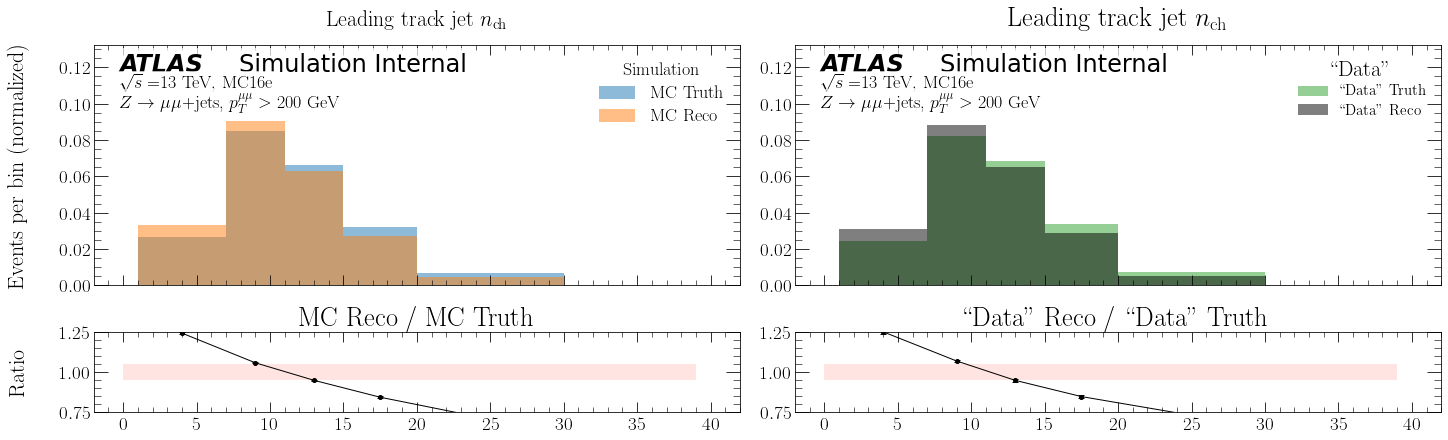

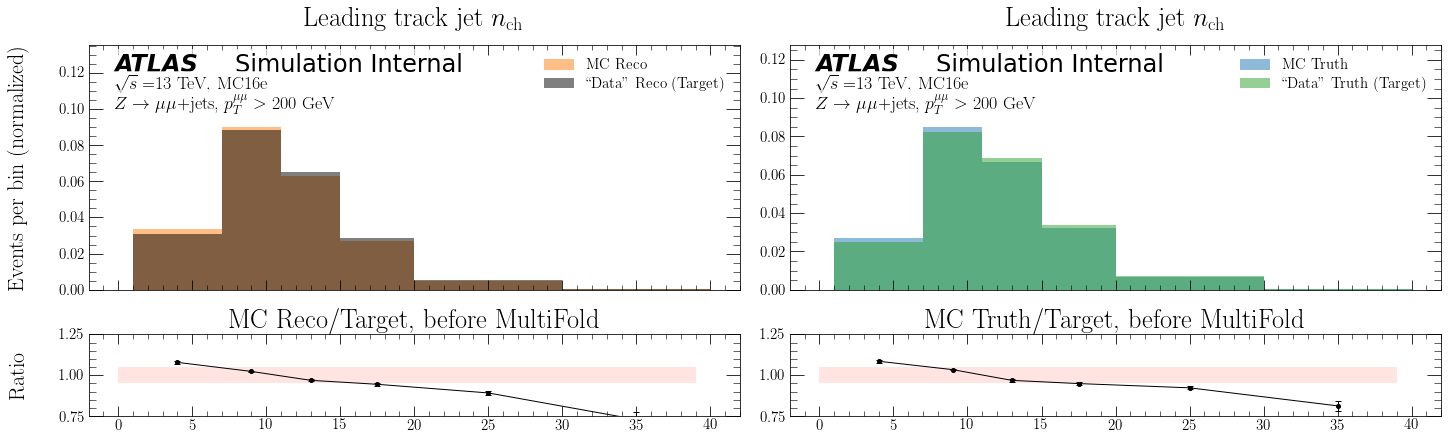

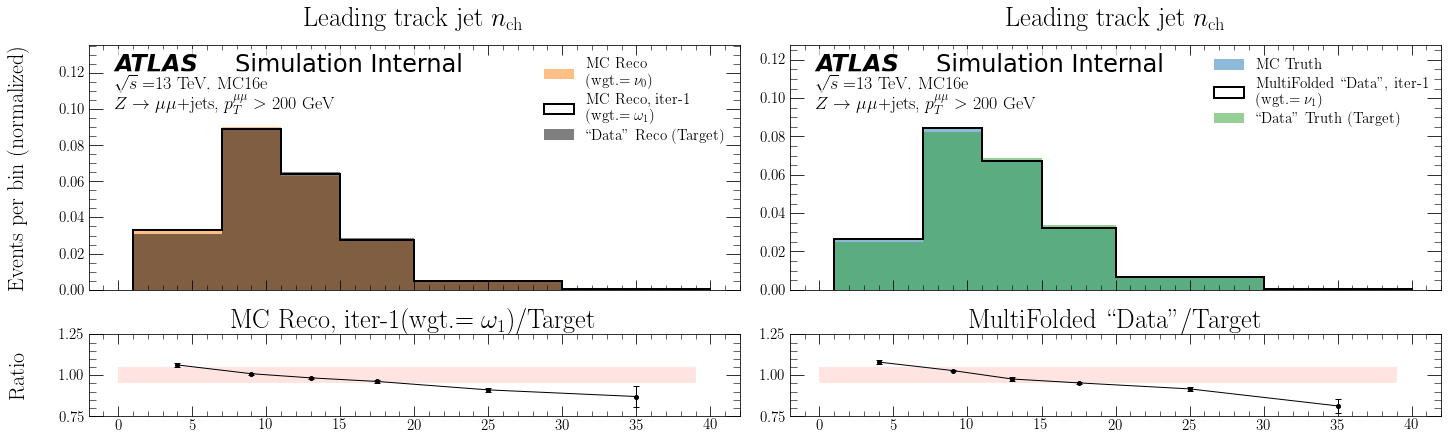

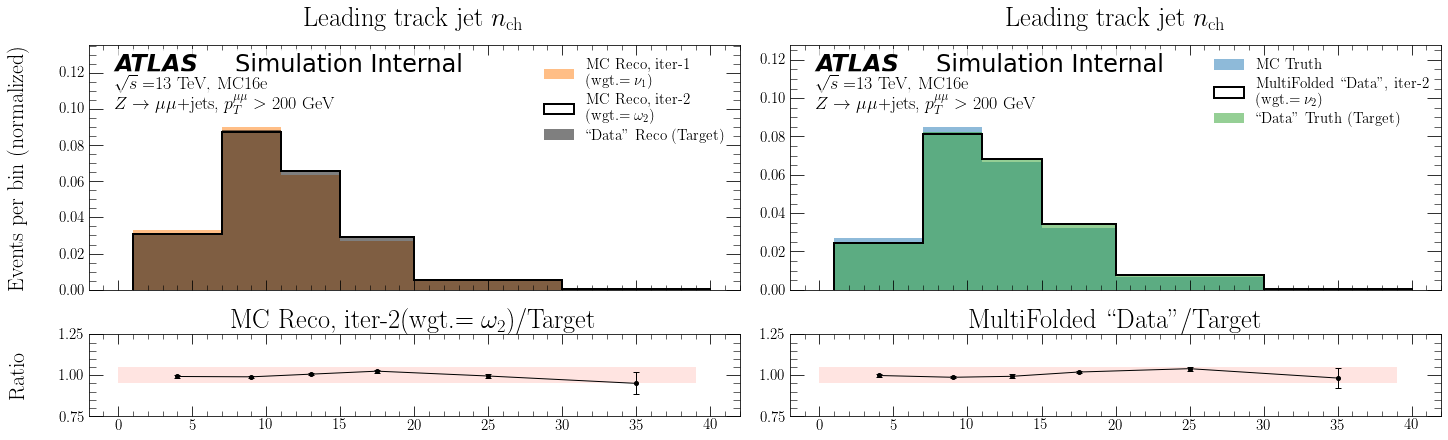

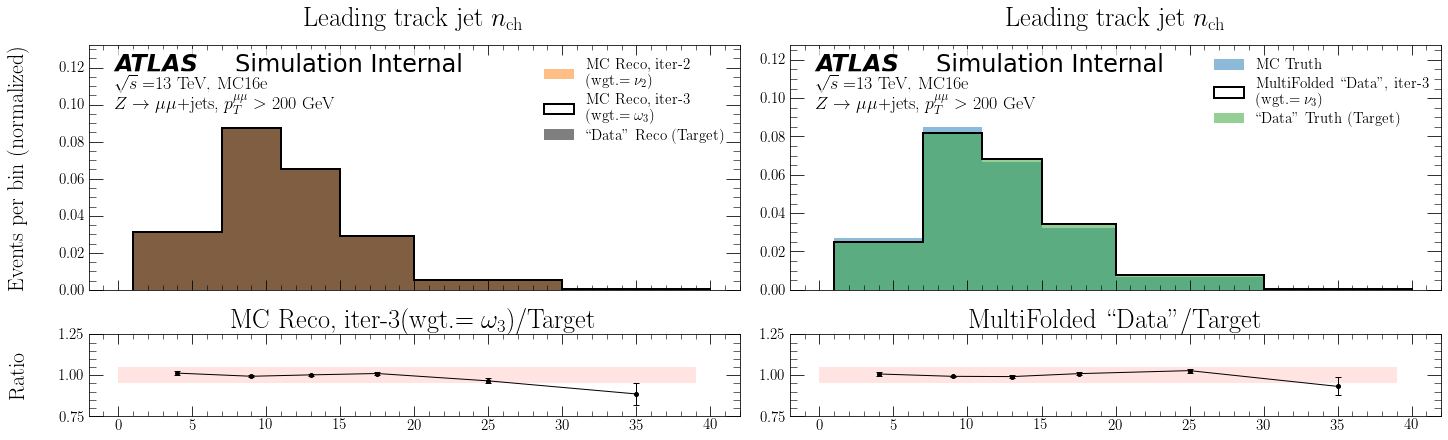

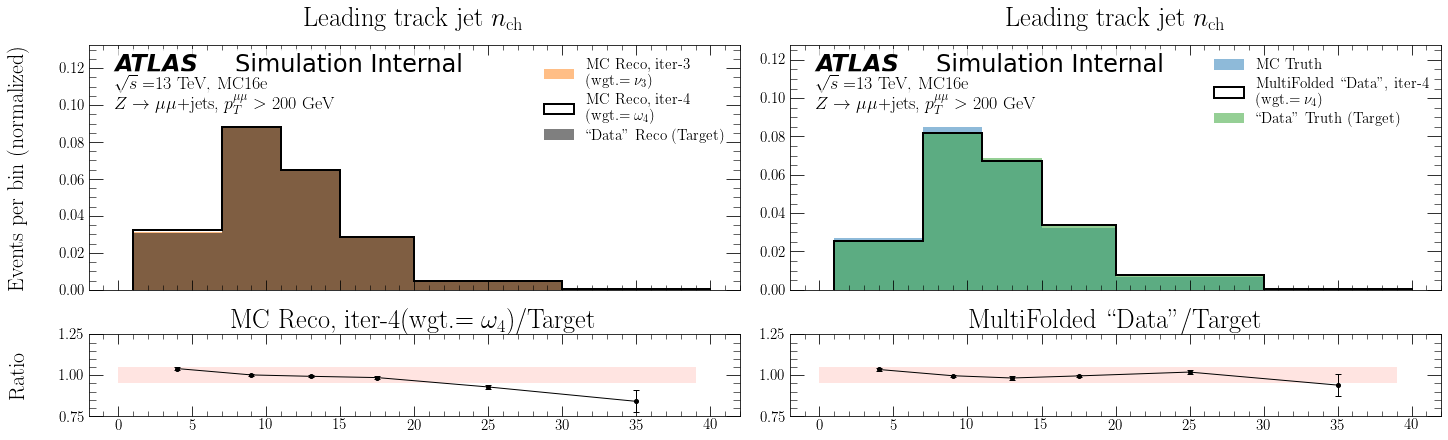

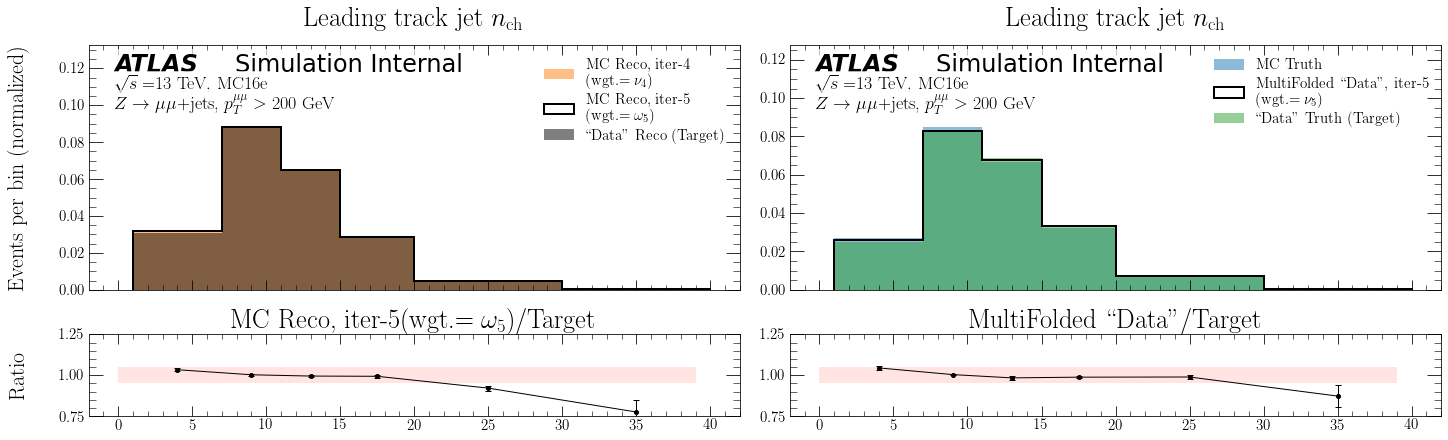

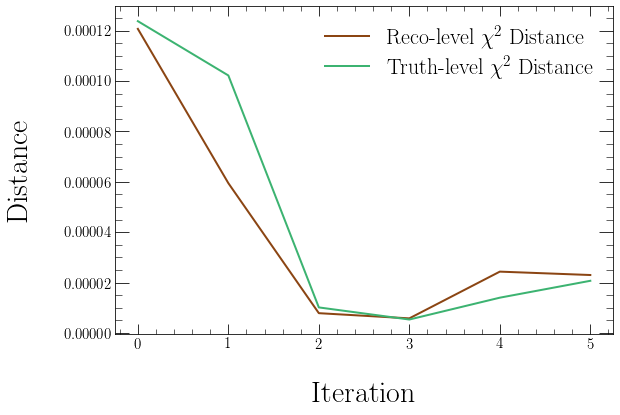

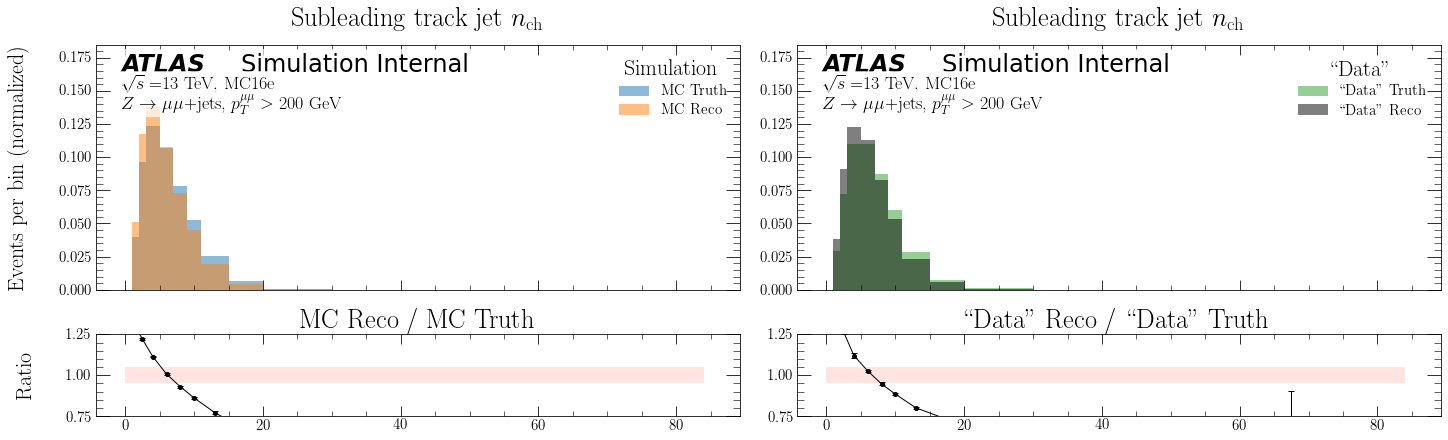

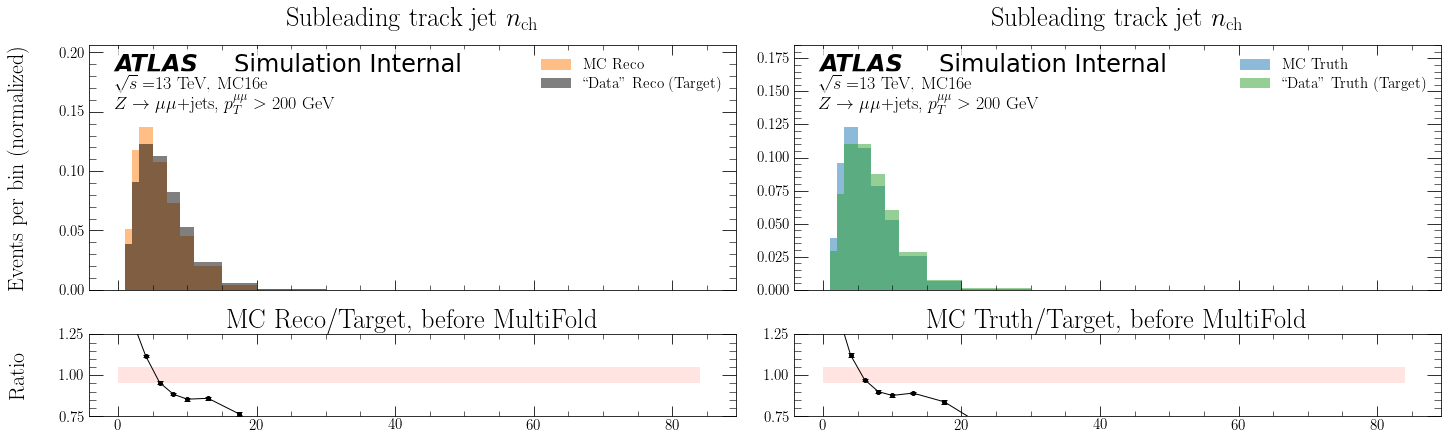

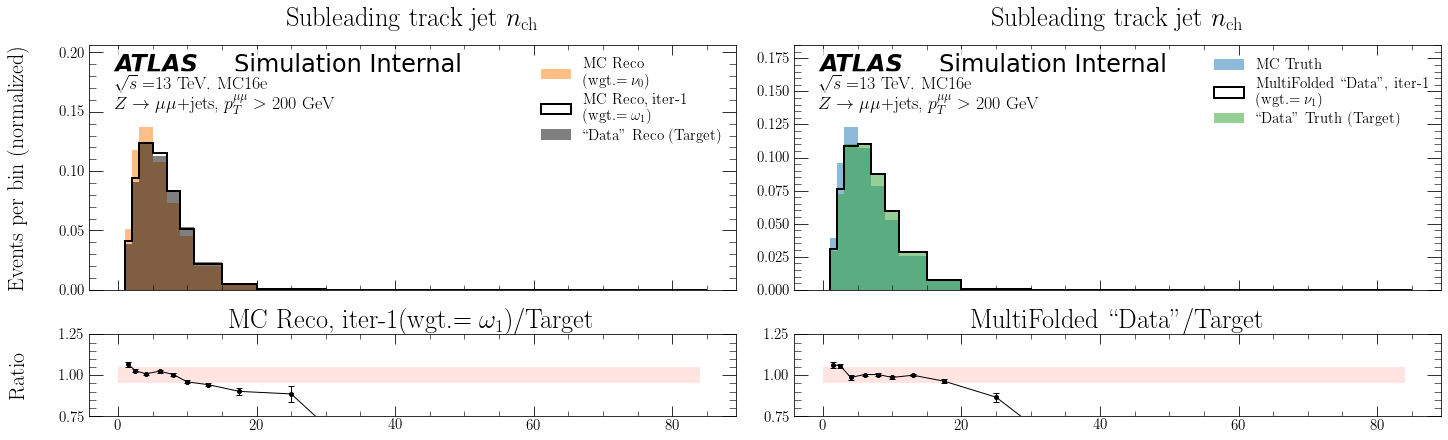

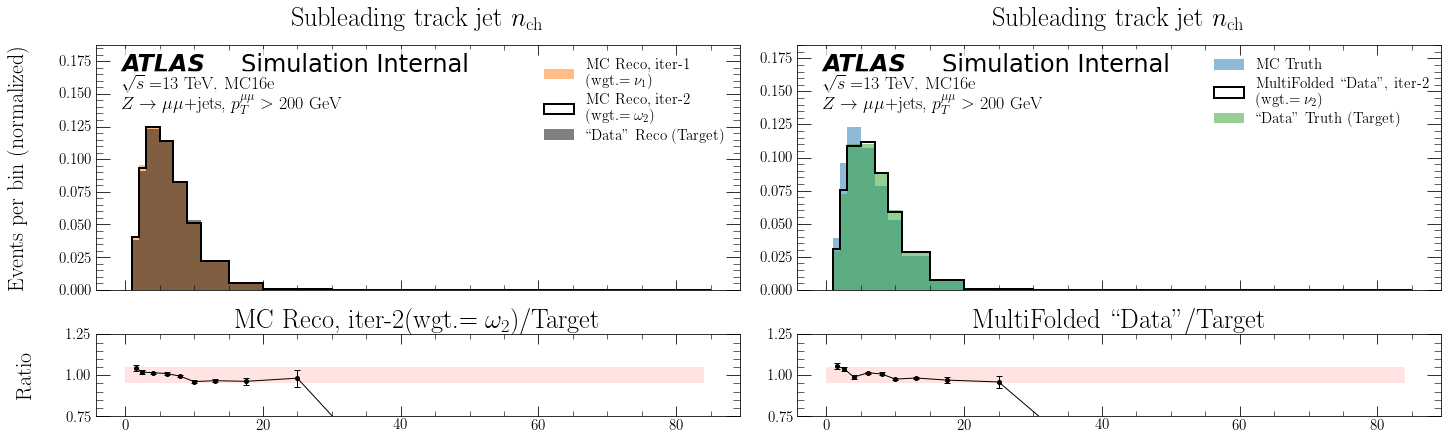

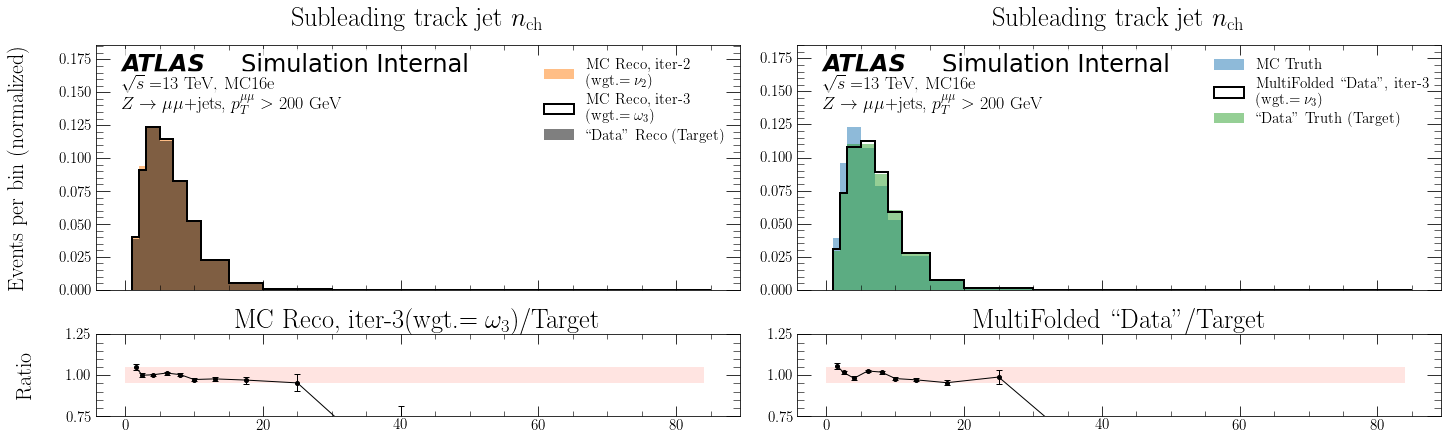

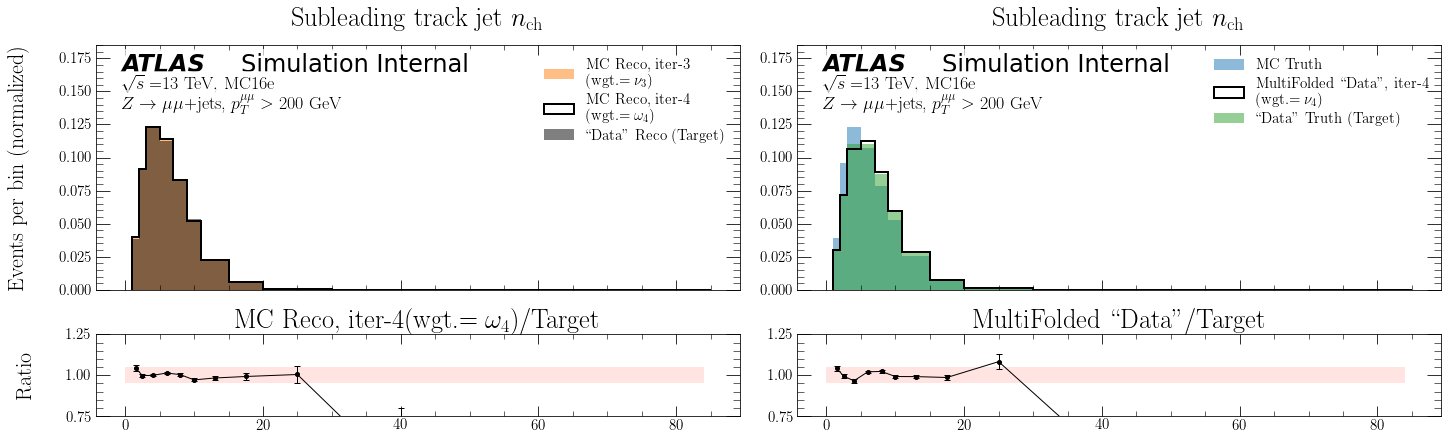

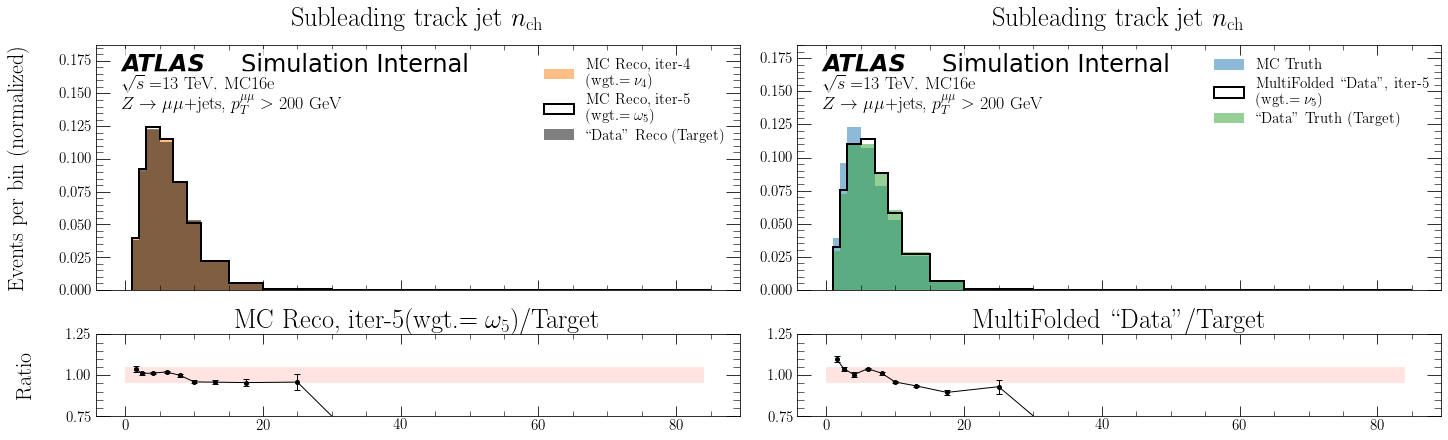

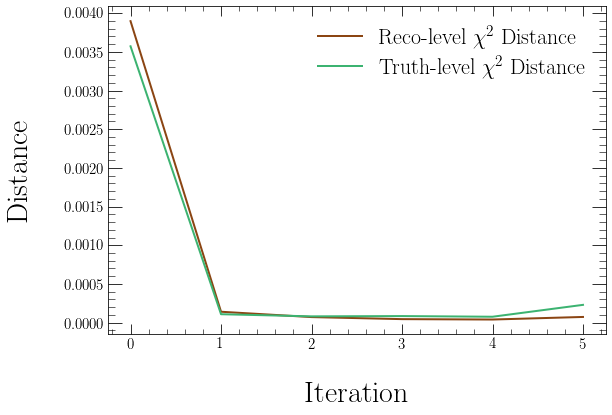

In [7]:
mc_truth_plots = [None] * len(inputs)
mc_reco_plots = [None] * len(inputs)
data_truth_plots = [None] * len(inputs)
data_reco_plots = [None] * len(inputs)

for i in tqdm(range(len(inputs))[:2], desc="Variables"):    
    bins = inputs[i]['bins']
    x_label = inputs[i]['plot_label']
    file_label = inputs[i]['file_label']
    os.makedirs(plot_dir+'MultiFold/'+file_label, exist_ok=True)
    save_label = plot_dir+'MultiFold/'+file_label+'/'+save_label0
    
    mc_truth_plots[i] = np.where(mc_pt200.truth_pass190, mc_pt200['truth_'+file_label], dummyval)
    mc_reco_plots[i] = np.where(mc_pt200.pass190, mc_pt200[file_label], dummyval)
    data_truth_plots[i] = data_truth_pt200['truth_'+file_label]
    data_reco_plots[i] = data_pt200[file_label]

    # Truth vs Reco
    plot_distributions(
        sim_truth=mc_truth_plots[i],
        sim_reco=mc_reco_plots[i],
        sim_truth_weights_MC=mc_pt200.weight_mc,
        sim_reco_weights_MC=mc_pt200.weight,
        data_truth=data_truth_plots[i],
        data_reco=data_reco_plots[i],
        data_truth_weights_MC=data_truth_pt200.weight_mc,
        data_reco_weights_MC=data_pt200.weight,
        bins=bins,
        x_label=x_label,
        save_label=save_label
    )
    
    # Unfolding
    plot_results(sim_truth=mc_truth_plots[i],
                 sim_reco=mc_reco_plots[i],
                 sim_truth_weights_MC=mc_pt200.weight_mc,
                 sim_reco_weights_MC=mc_pt200.weight,
                 data_truth=data_truth_plots[i],
                 data_reco=data_reco_plots[i],
                 data_truth_weights_MC=data_truth_pt200.weight_mc,
                 data_reco_weights_MC=data_pt200.weight,
                 weights=weights[:,:,mc_filter],
                 bins=bins,
                 x_label=x_label,
                 flavor_label='MultiFold',
                 save_label=save_label)

# Look at some derived variables

In [8]:
save_label0 = 'derived'

In [37]:
[dict['file_label'] for dict in inputs] # list of actual variables used in unfolding

['Ntracks_trackj1',
 'Ntracks_trackj2',
 'm_trackj1',
 'm_trackj2',
 'pT_trackj1',
 'pT_trackj2',
 'y_trackj1',
 'y_trackj2',
 'phi_trackj1',
 'phi_trackj2',
 'tau1_trackj1',
 'tau1_trackj2',
 'tau2_trackj1',
 'tau2_trackj2',
 'tau3_trackj1',
 'tau3_trackj2',
 'pT_ll',
 'y_ll',
 'pT_l1',
 'pT_l2',
 'eta_l1',
 'eta_l2',
 'phi_l1',
 'phi_l2']

### tau_2 / tau_1

In [9]:
leadtrack_tau1_index = [dict['file_label'] for dict in inputs].index('tau1_trackj1')
leadtrack_tau1 = inputs[leadtrack_tau1_index]

leadtrack_tau2_index = [dict['file_label'] for dict in inputs].index('tau2_trackj1')
leadtrack_tau2 = inputs[leadtrack_tau2_index]

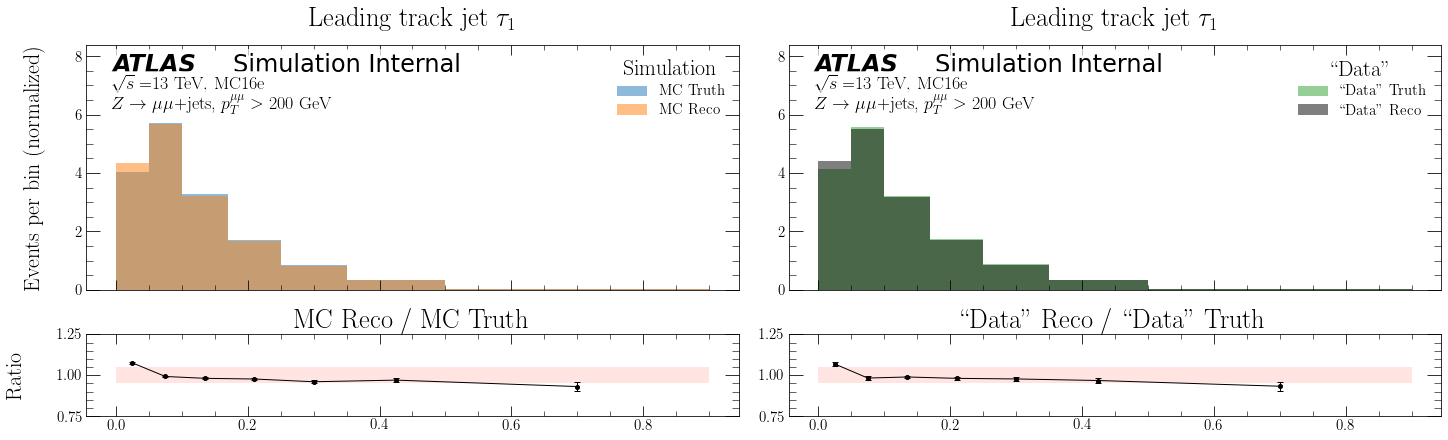

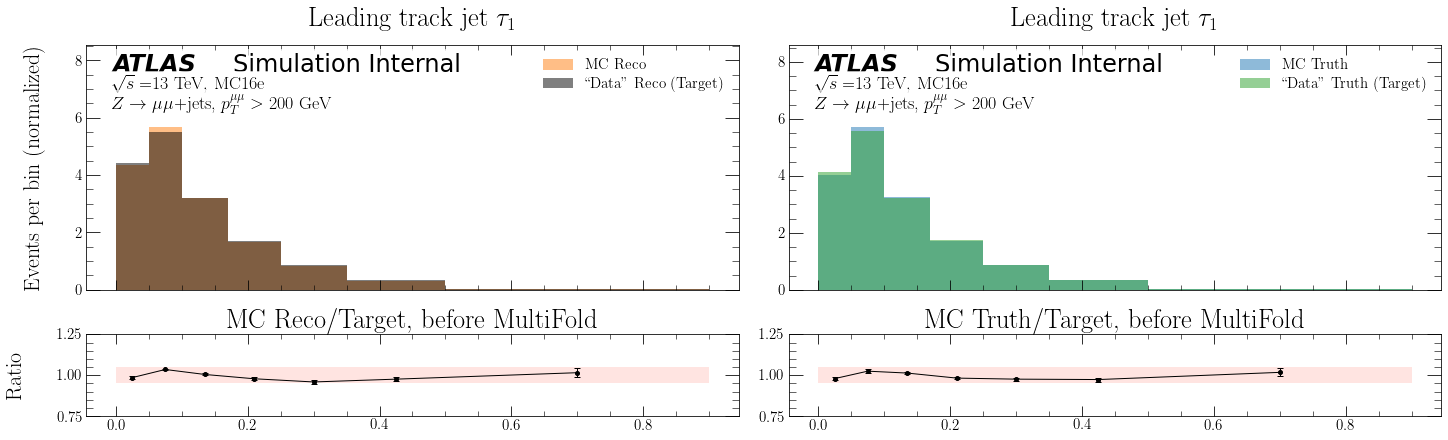

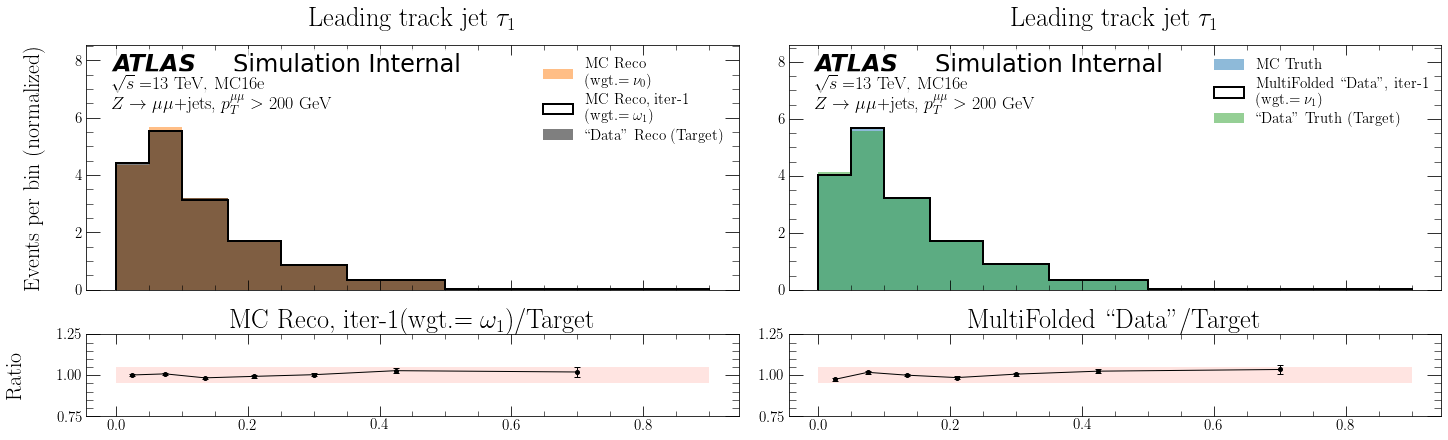

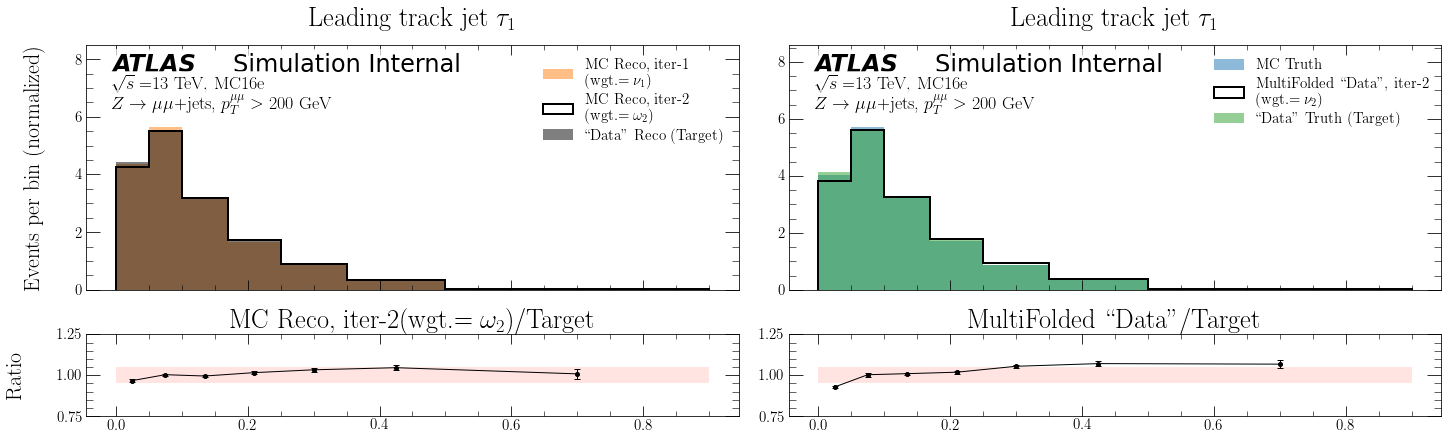

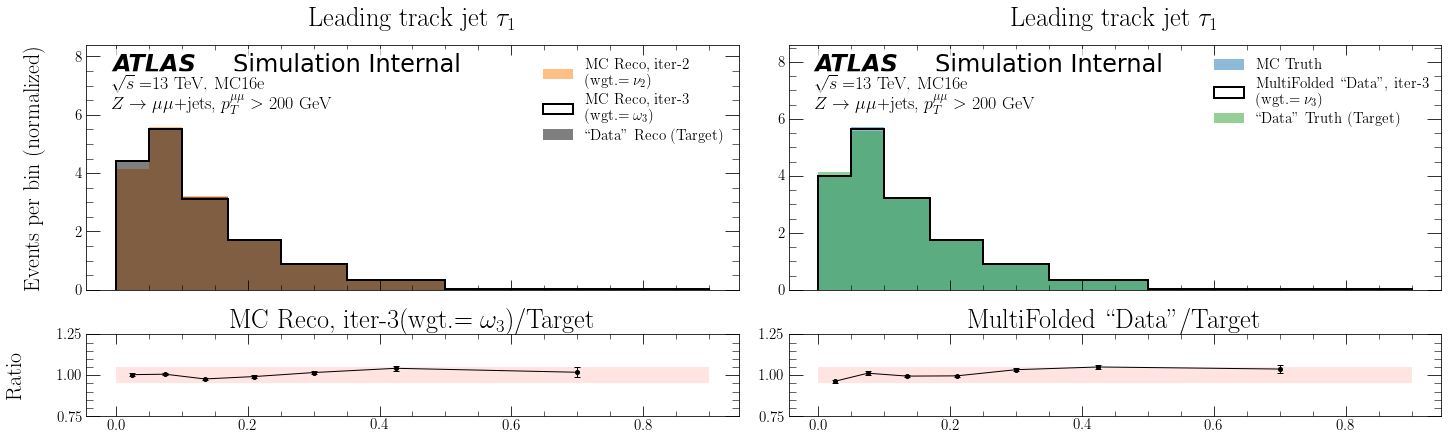

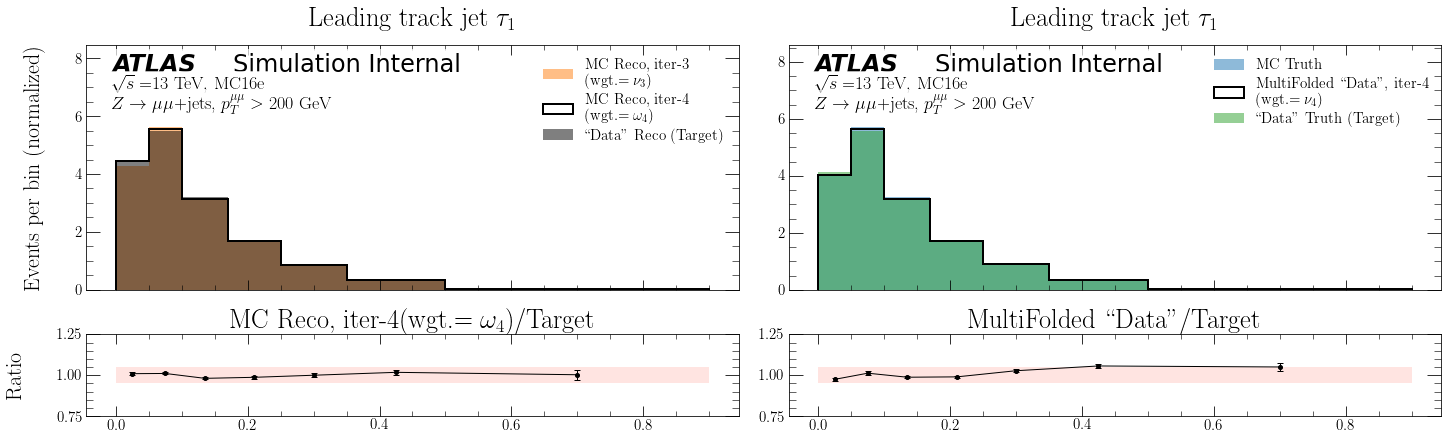

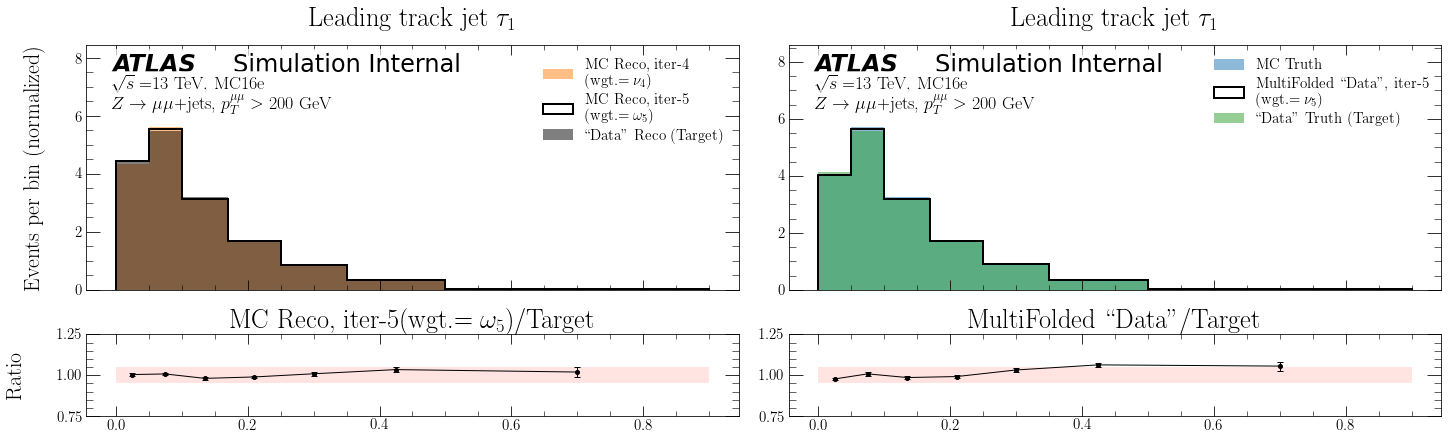

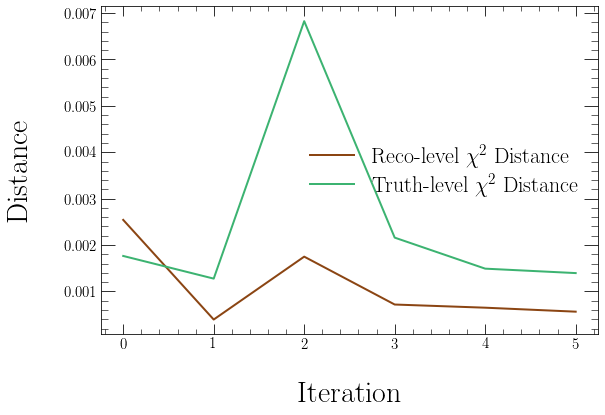

In [10]:
# Tau1 

mc_truth_plot = np.where(mc_pt200.truth_pass190, mc_pt200['truth_'+leadtrack_tau1['file_label']], dummyval)
mc_reco_plot = np.where(mc_pt200.pass190, mc_pt200[leadtrack_tau1['file_label']], dummyval)
data_truth_plot = data_truth_pt200['truth_'+leadtrack_tau1['file_label']]
data_reco_plot = data_pt200[leadtrack_tau1['file_label']]

# Truth vs Reco
plot_distributions(
    sim_truth=mc_truth_plot,
    sim_reco=mc_reco_plot,
    sim_truth_weights_MC=mc_pt200.weight_mc,
    sim_reco_weights_MC=mc_pt200.weight,
    data_truth=data_truth_plot,
    data_reco=data_reco_plot,
    data_truth_weights_MC=data_truth_pt200.weight_mc,
    data_reco_weights_MC=data_pt200.weight,
    bins=leadtrack_tau1['bins'],
    x_label=leadtrack_tau1['plot_label'],
    save_label=plot_dir + '/MultiFold/' + leadtrack_tau1['file_label'] + '/' + save_label0 + '-MultiFold-' + leadtrack_tau1['file_label']
)

# Unfolding 
plot_results(sim_truth=mc_truth_plot,
             sim_reco=mc_reco_plot,
             sim_truth_weights_MC=mc_pt200.weight_mc,
             sim_reco_weights_MC=mc_pt200.weight,
             data_truth=data_truth_plot,
             data_reco=data_reco_plot,
             data_truth_weights_MC=data_truth_pt200.weight_mc,
             data_reco_weights_MC=data_pt200.weight,
             weights=weights[:,:,mc_filter],
             flavor_label = "MultiFold",
             bins=leadtrack_tau1['bins'],
             x_label=leadtrack_tau1['plot_label'],
             save_label=plot_dir + '/MultiFold/' + leadtrack_tau1['file_label'] + '/' + save_label0 + '-MultiFold-' + leadtrack_tau1['file_label']
            )

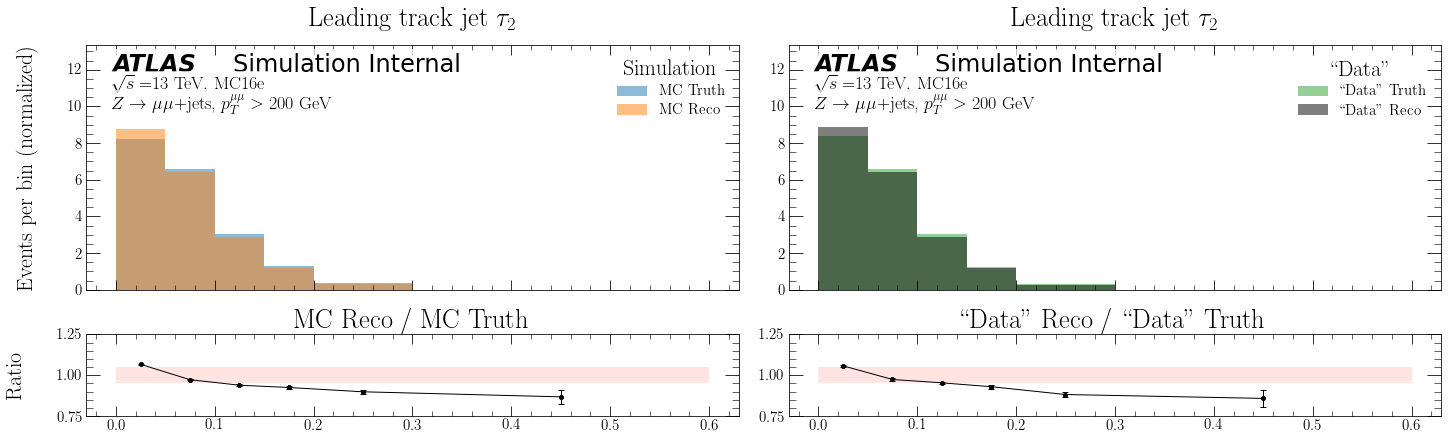

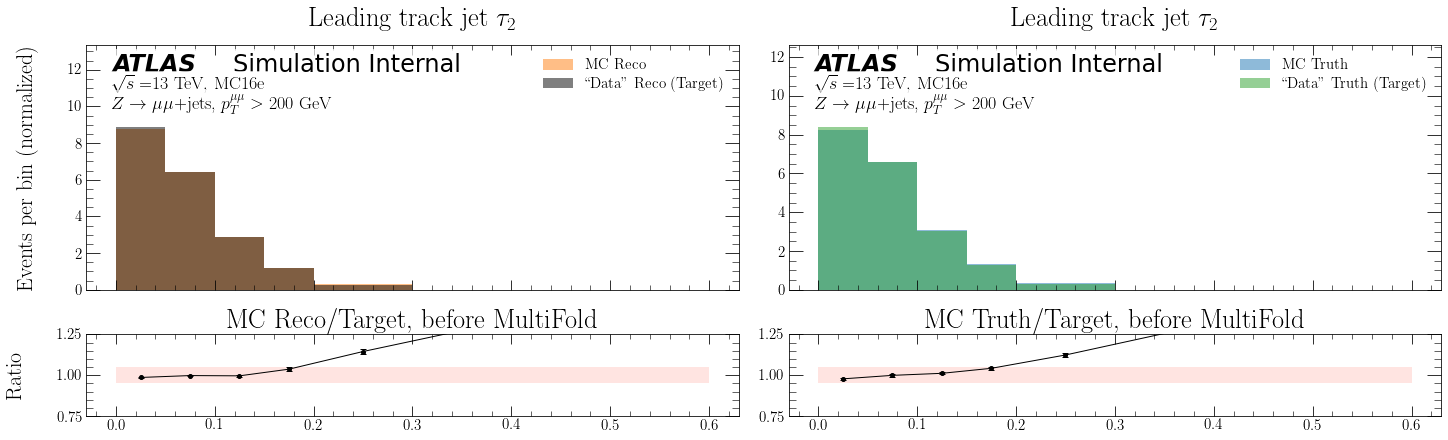

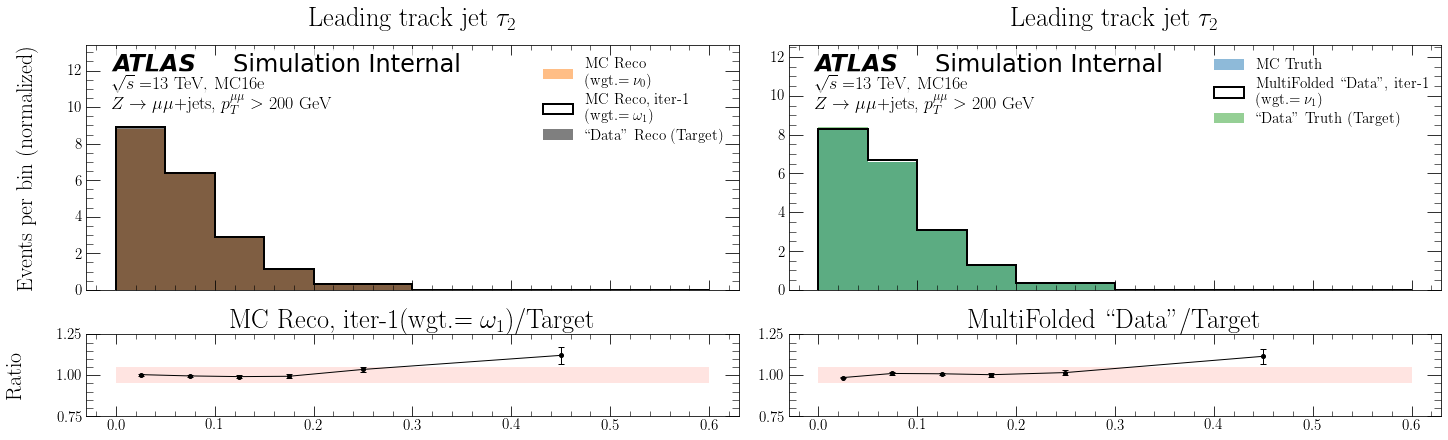

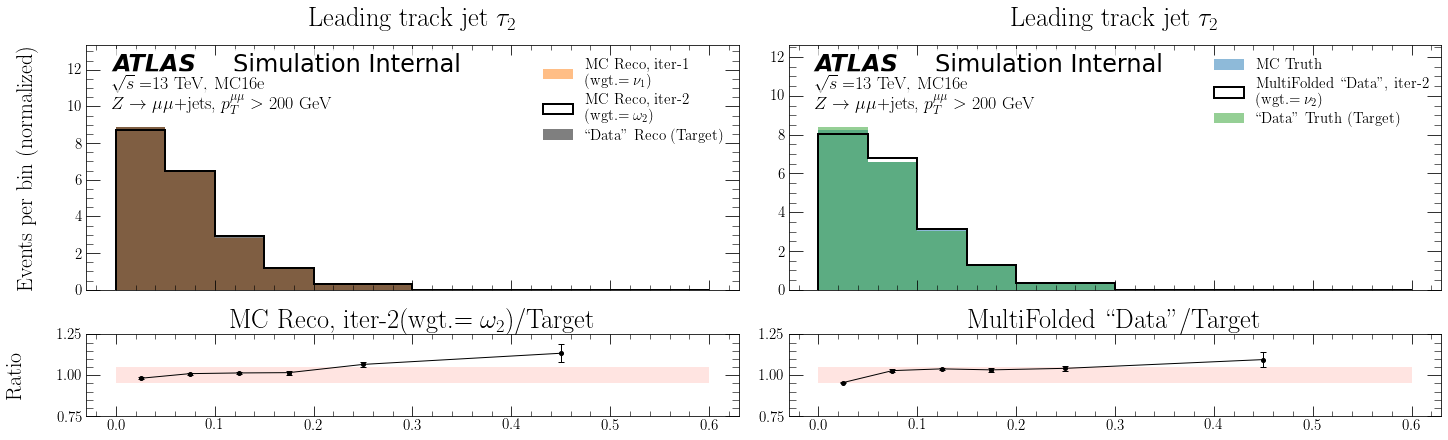

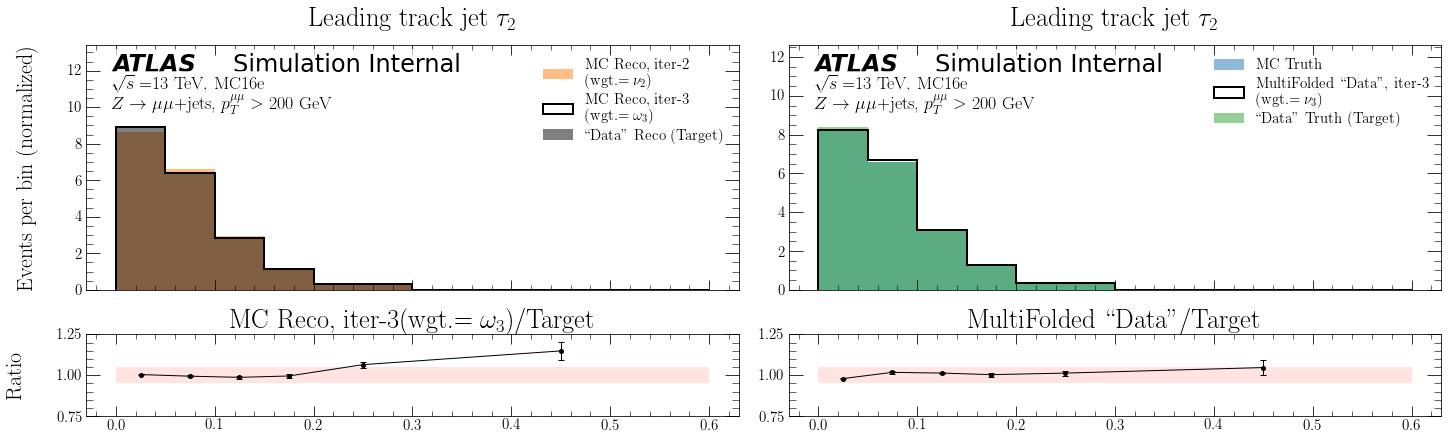

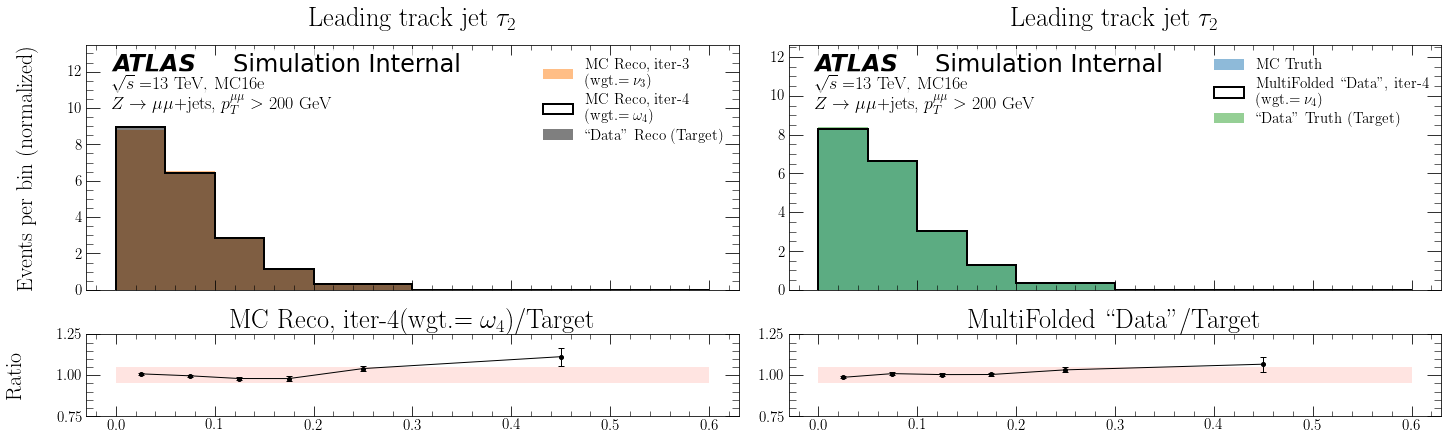

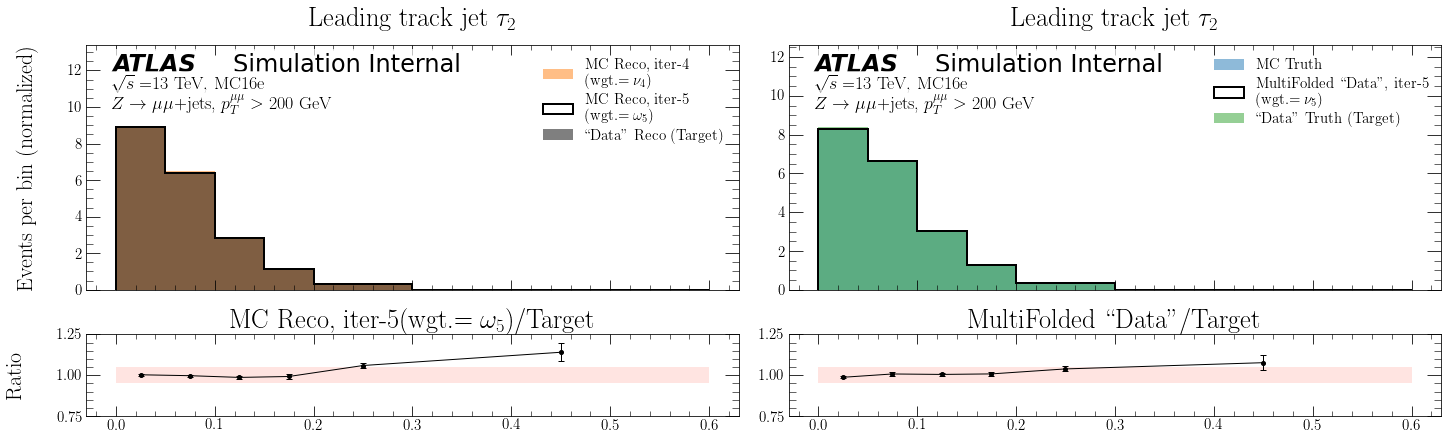

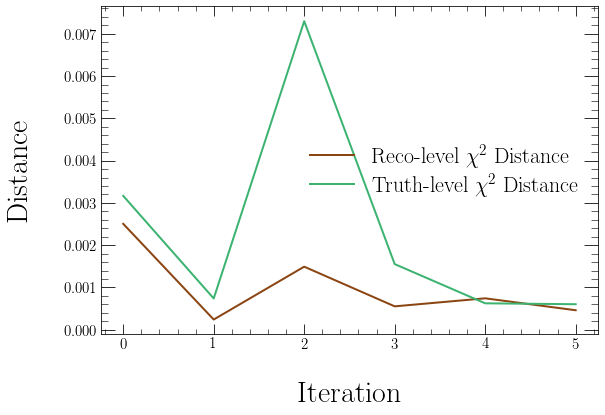

In [11]:
# Tau2 

mc_truth_plot = np.where(mc_pt200.truth_pass190, mc_pt200['truth_'+leadtrack_tau2['file_label']], dummyval)
mc_reco_plot = np.where(mc_pt200.pass190, mc_pt200[leadtrack_tau2['file_label']], dummyval)
data_truth_plot = data_truth_pt200['truth_'+leadtrack_tau2['file_label']]
data_reco_plot = data_pt200[leadtrack_tau2['file_label']]

# Truth vs Reco
plot_distributions(
    sim_truth=mc_truth_plot,
    sim_reco=mc_reco_plot,
    sim_truth_weights_MC=mc_pt200.weight_mc,
    sim_reco_weights_MC=mc_pt200.weight,
    data_truth=data_truth_plot,
    data_reco=data_reco_plot,
    data_truth_weights_MC=data_truth_pt200.weight_mc,
    data_reco_weights_MC=data_pt200.weight,
    bins=leadtrack_tau2['bins'],
    x_label=leadtrack_tau2['plot_label'],
    save_label=plot_dir + '/MultiFold/' + leadtrack_tau2['file_label'] + '/' + save_label0 + '-MultiFold-' + leadtrack_tau2['file_label']
)

# Unfolding 
plot_results(sim_truth=mc_truth_plot,
             sim_reco=mc_reco_plot,
             sim_truth_weights_MC=mc_pt200.weight_mc,
             sim_reco_weights_MC=mc_pt200.weight,
             data_truth=data_truth_plot,
             data_reco=data_reco_plot,
             data_truth_weights_MC=data_truth_pt200.weight_mc,
             data_reco_weights_MC=data_pt200.weight,
             weights=weights[:,:,mc_filter],
            flavor_label = "MultiFold",
             bins=leadtrack_tau2['bins'],
             x_label=leadtrack_tau2['plot_label'],
             save_label=plot_dir + '/MultiFold/' + leadtrack_tau2['file_label'] + '/' + save_label0 + '-MultiFold-' + leadtrack_tau2['file_label']
            )

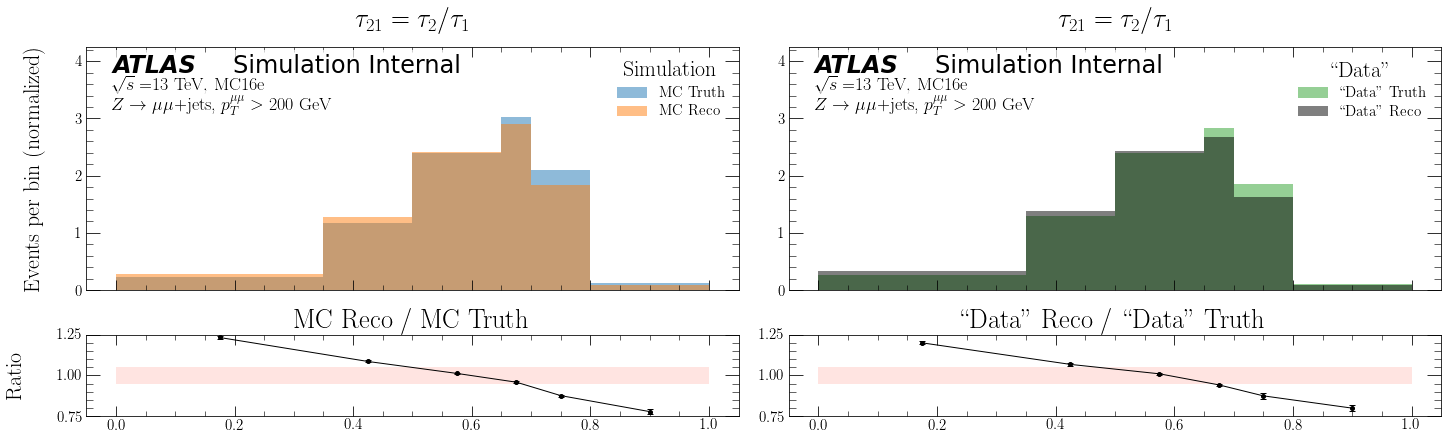

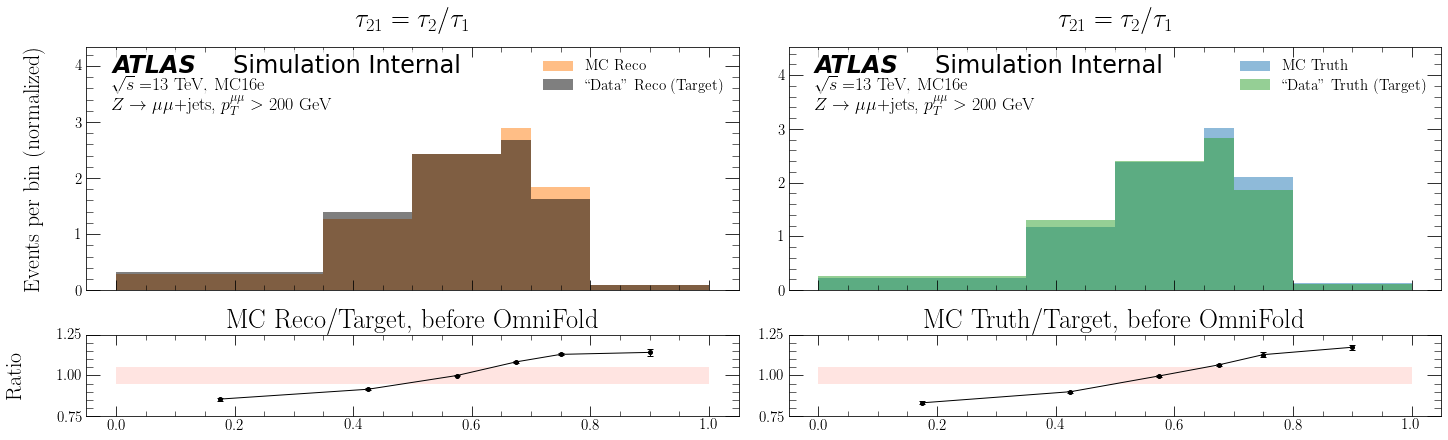

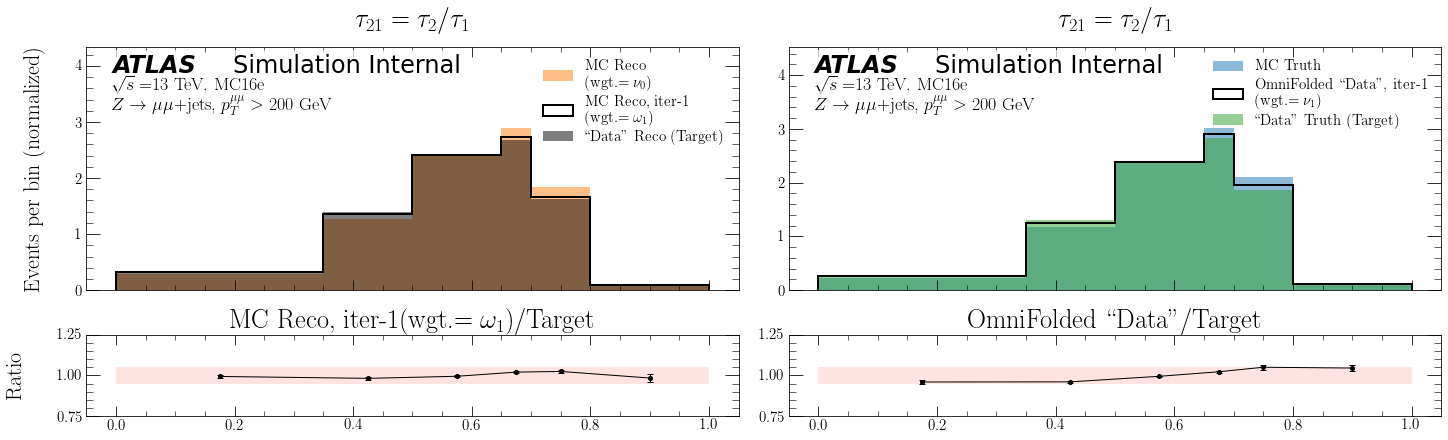

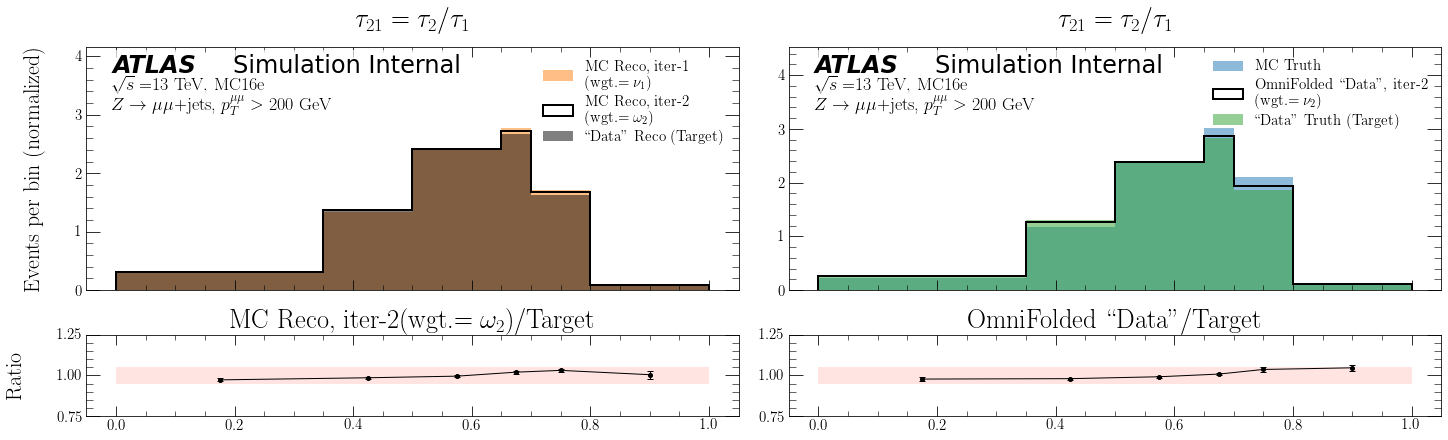

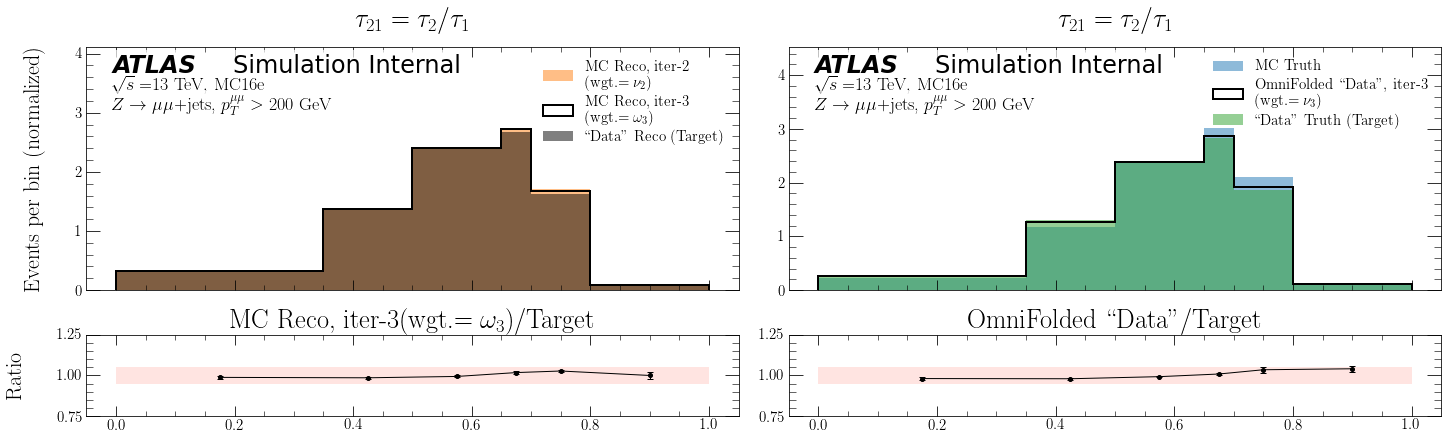

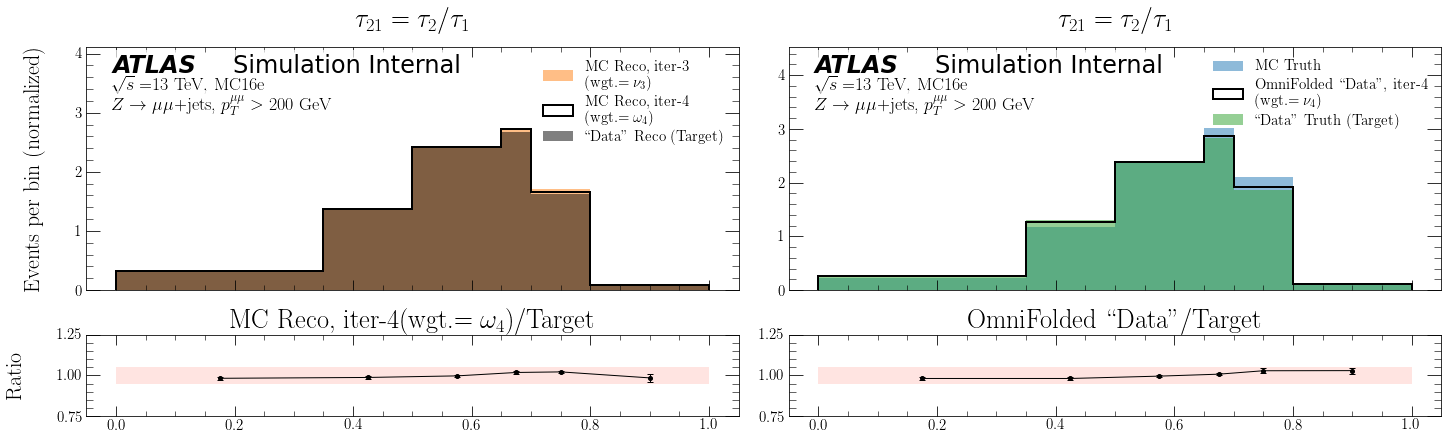

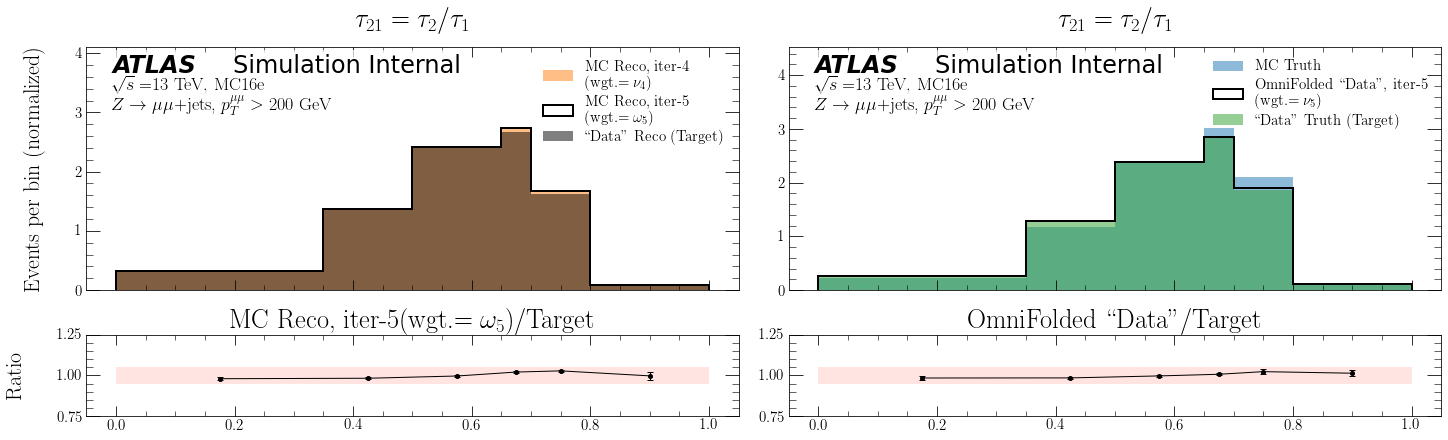

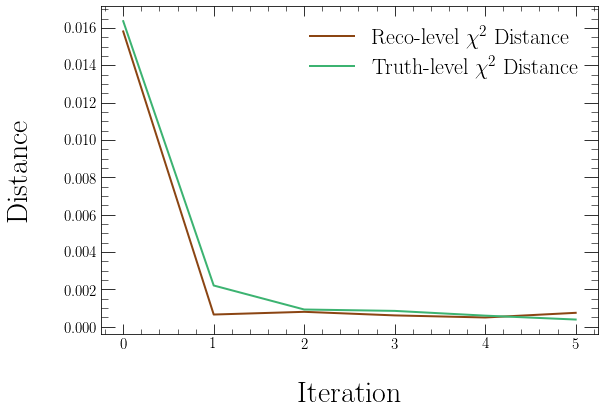

In [13]:
# tau2/tau1 

bins = np.array([0., 0.35, 0.5, 0.65, 0.7, 0.8, 1.0])
save_label=plot_dir + '/MultiFold/' + 'tau_21' + '/' + save_label0 + '-MultiFold-' + 'tau_21'
os.makedirs(plot_dir+'MultiFold/'+ 'tau_21', exist_ok=True)

mc_truth_plot = np.where(mc_pt200.truth_pass190, mc_pt200['truth_'+leadtrack_tau2['file_label']]/mc_pt200['truth_'+leadtrack_tau1['file_label']], dummyval)
mc_reco_plot = np.where(mc_pt200.pass190, mc_pt200[leadtrack_tau2['file_label']]/mc_pt200[leadtrack_tau1['file_label']], dummyval)
data_truth_plot = data_truth_pt200['truth_'+leadtrack_tau2['file_label']]/data_truth_pt200['truth_'+leadtrack_tau1['file_label']]
data_reco_plot = data_pt200[leadtrack_tau2['file_label']]/data_pt200[leadtrack_tau1['file_label']]

# Truth vs Reco
plot_distributions(
    sim_truth=mc_truth_plot,
    sim_reco=mc_reco_plot,
    sim_truth_weights_MC=mc_pt200.weight_mc,
    sim_reco_weights_MC=mc_pt200.weight,
    data_truth=data_truth_plot,
    data_reco=data_reco_plot,
    data_truth_weights_MC=data_truth_pt200.weight_mc,
    data_reco_weights_MC=data_pt200.weight,
    bins=bins,
    x_label=r"$\tau_{21}=\tau_2/\tau_1$",
    save_label=save_label
)

# Unfolding 
plot_results(
    sim_truth=mc_truth_plot,
    sim_reco=mc_reco_plot,
    sim_truth_weights_MC=mc_pt200.weight_mc,
    sim_reco_weights_MC=mc_pt200.weight,
    data_truth=data_truth_plot,
    data_reco=data_reco_plot,
    data_truth_weights_MC=data_truth_pt200.weight_mc,
    data_reco_weights_MC=data_pt200.weight,
    weights=weights[:,:,mc_filter],
    bins=bins,
    x_label=r"$\tau_{21}=\tau_2/\tau_1$",
    save_label=save_label
)

### $\Delta R(ll, j_1)$

In [68]:
import vector

def ll(pt_l1, eta_l1, phi_l1, pt_l2, eta_l2, phi_l2): 
        l1 = vector.array({"pt": pt_l1, "eta": eta_l1, "phi": phi_l1, "m": np.zeros(len(pt_l1))})
        l2 = vector.array({"pt": pt_l2, "eta": eta_l2, "phi": phi_l2, "m": np.zeros(len(pt_l2))})
        return l1.add(l2)
    
def delta_r(y_ll, y_trackj1, phi_ll, phi_trackj1):
    delta_y = y_ll - y_trackj1
    delta_phi = phi_ll - phi_trackj1
    return np.sqrt(delta_y**2 + delta_phi**2)

/tmp/ipykernel_9048/370304111.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mc_pt200['truth_phi_ll'] = ll(mc_pt200['truth_pT_l1'], mc_pt200['truth_eta_l1'], mc_pt200['truth_phi_l1'],
/tmp/ipykernel_9048/370304111.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mc_pt200['phi_ll'] = ll(mc_pt200['pT_l1'], mc_pt200['eta_l1'], mc_pt200['phi_l1'],
/tmp/ipykernel_9048/370304111.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

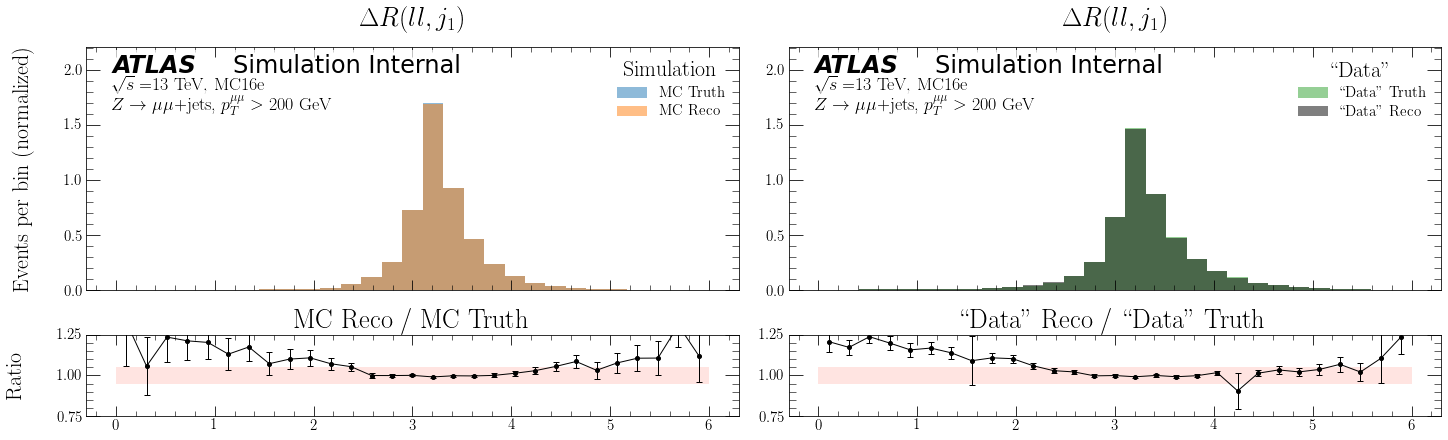

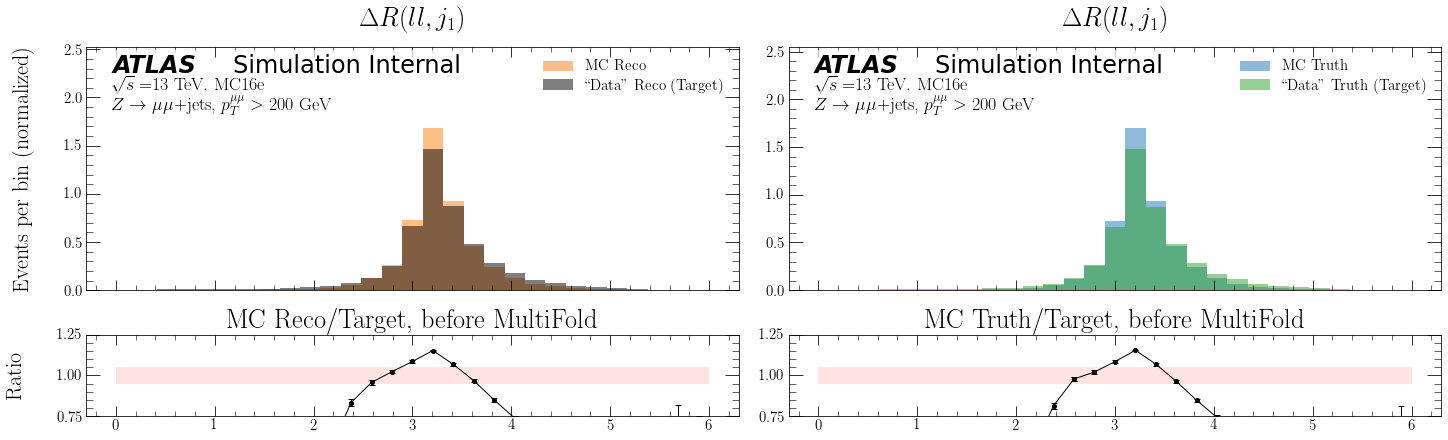

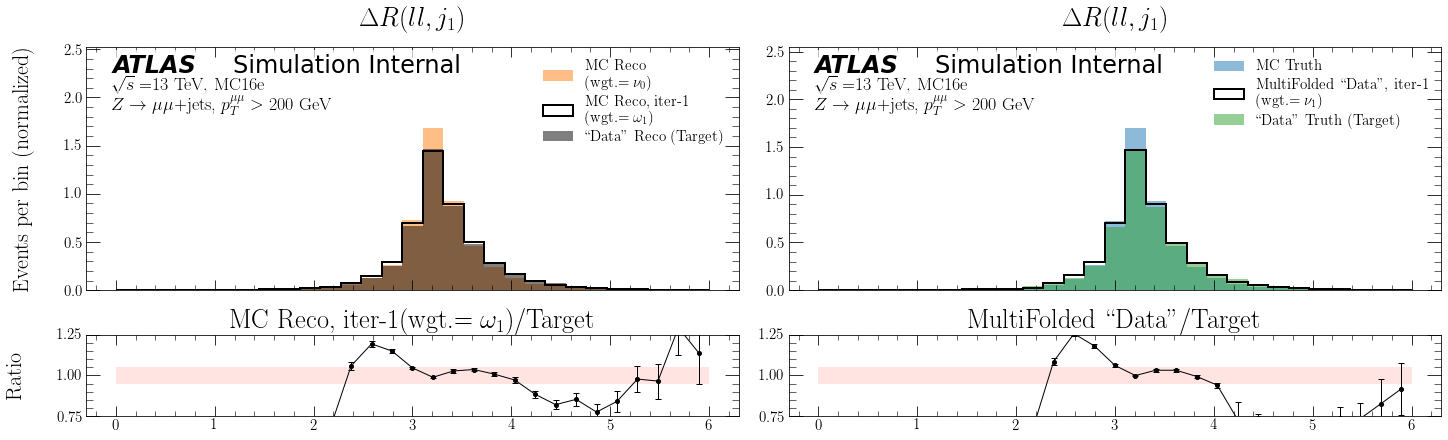

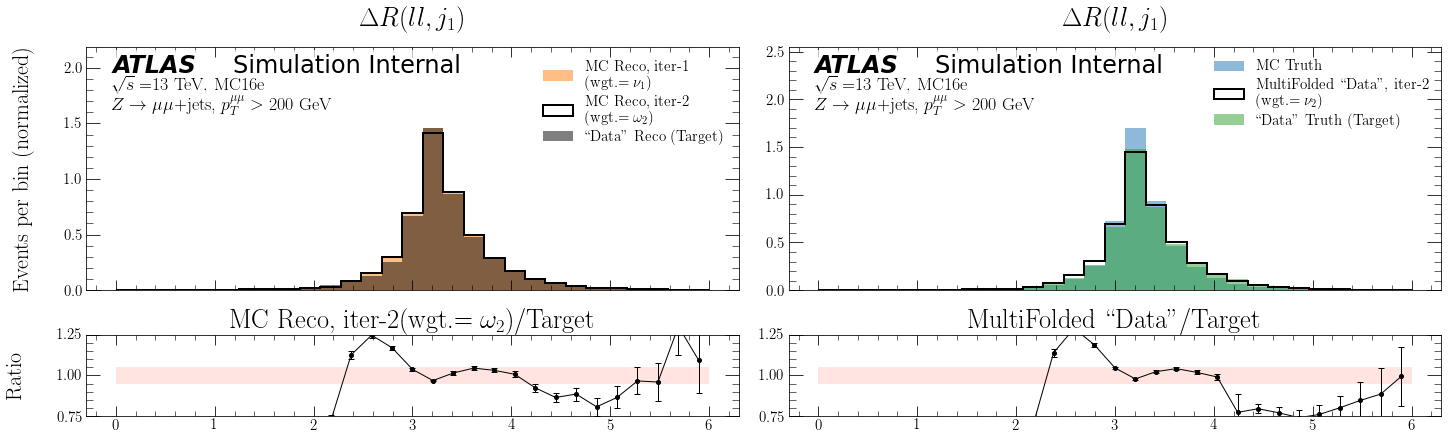

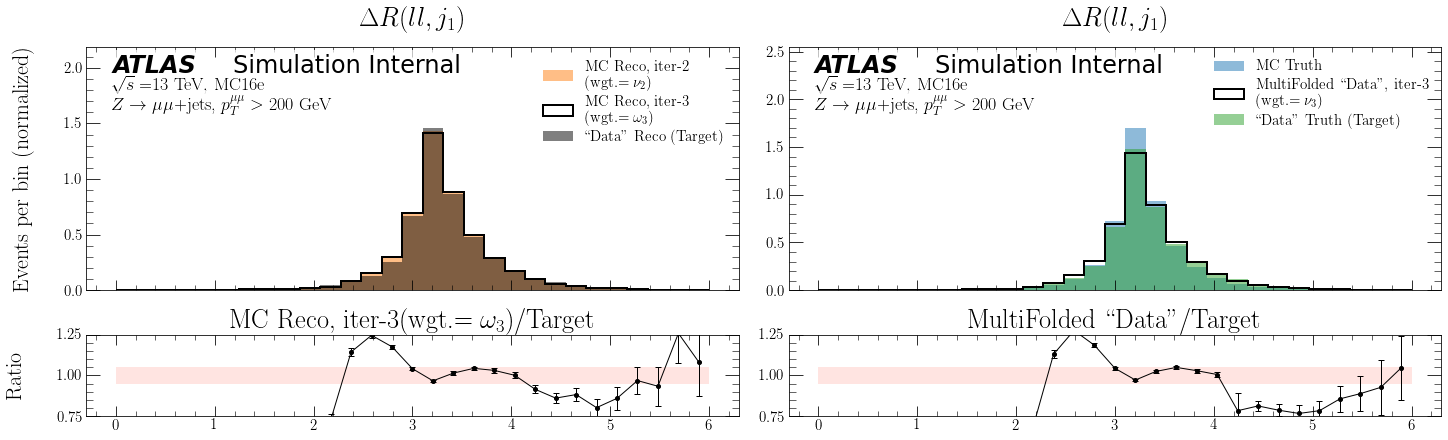

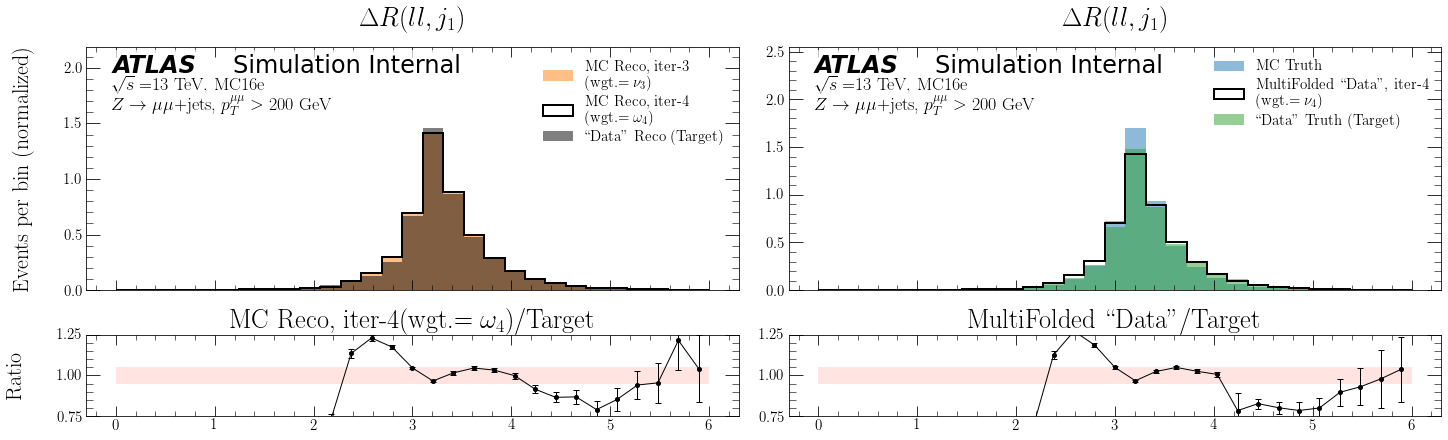

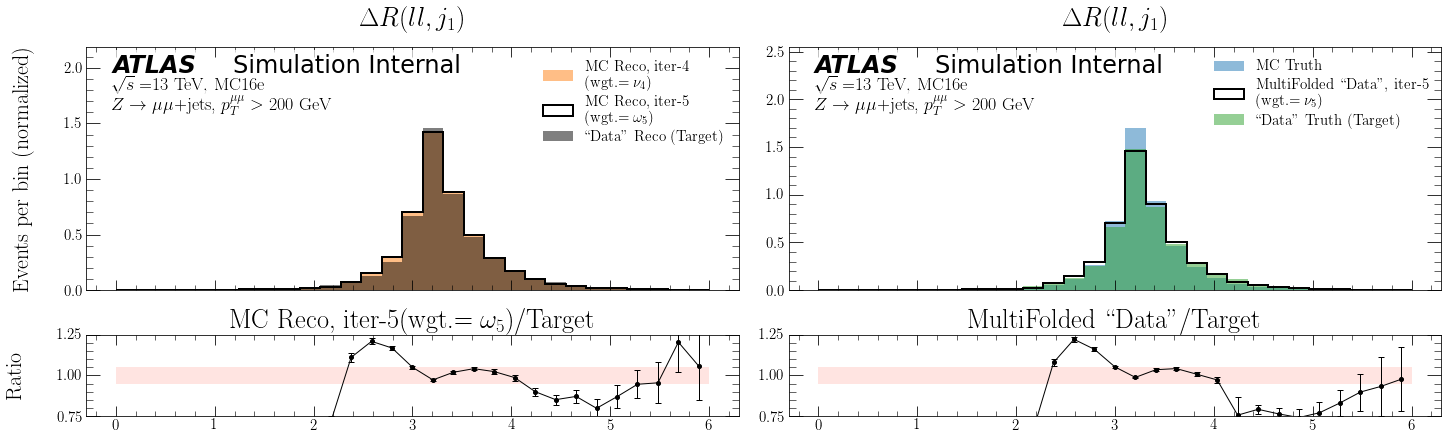

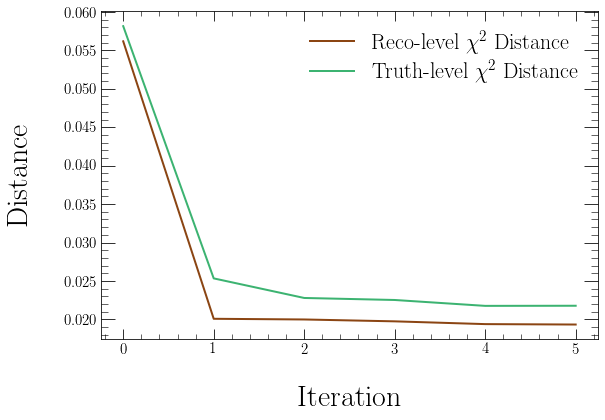

In [80]:
# DeltaR

### Define the combined dilepton phi first, before calculating DeltaR
mc_pt200['truth_phi_ll'] = ll(mc_pt200['truth_pT_l1'], mc_pt200['truth_eta_l1'], mc_pt200['truth_phi_l1'], 
                              mc_pt200['truth_pT_l2'], mc_pt200['truth_eta_l2'], mc_pt200['truth_phi_l2']).phi
mc_pt200['phi_ll'] = ll(mc_pt200['pT_l1'], mc_pt200['eta_l1'], mc_pt200['phi_l1'], 
                        mc_pt200['pT_l2'], mc_pt200['eta_l2'], mc_pt200['phi_l2']).phi
data_truth_pt200['truth_phi_ll'] = ll(data_truth_pt200['truth_pT_l1'], data_truth_pt200['truth_eta_l1'], data_truth_pt200['truth_phi_l1'], 
                                      data_truth_pt200['truth_pT_l2'], data_truth_pt200['truth_eta_l2'], data_truth_pt200['truth_phi_l2']).phi
data_pt200['phi_ll'] = ll(data_pt200['pT_l1'], data_pt200['eta_l1'], data_pt200['phi_l1'], 
                          data_pt200['pT_l2'], data_pt200['eta_l2'], data_pt200['phi_l2']).phi

mc_truth_plot = np.where(mc_pt200.truth_pass190, delta_r(mc_pt200['truth_y_ll'], mc_pt200['truth_y_trackj1'], mc_pt200['truth_phi_ll'], mc_pt200['truth_phi_trackj1']), dummyval)
mc_reco_plot = np.where(mc_pt200.pass190, delta_r(mc_pt200['y_ll'], mc_pt200['y_trackj1'], mc_pt200['phi_ll'], mc_pt200['phi_trackj1']), dummyval)
data_truth_plot = delta_r(data_truth_pt200['truth_y_ll'], data_truth_pt200['truth_y_trackj1'], data_truth_pt200['truth_phi_ll'], data_truth_pt200['truth_phi_trackj1'])
data_reco_plot = delta_r(data_pt200['y_ll'], data_pt200['y_trackj1'], data_pt200['phi_ll'], data_pt200['phi_trackj1'])

bins = np.linspace(0,6,30)
os.makedirs(plot_dir+'MultiFold/'+ 'DeltaR', exist_ok=True)

# Truth vs Reco
plot_distributions(
    sim_truth=mc_truth_plot,
    sim_reco=mc_reco_plot,
    sim_truth_weights_MC=mc_pt200.weight_mc,
    sim_reco_weights_MC=mc_pt200.weight,
    data_truth=data_truth_plot,
    data_reco=data_reco_plot,
    data_truth_weights_MC=data_truth_pt200.weight_mc,
    data_reco_weights_MC=data_pt200.weight,
    bins=bins,
    x_label=r'$\Delta R(ll,j_1)$',
    save_label=plot_dir + '/MultiFold/' + 'DeltaR' + '/' + save_label0 + '-MultiFold-' + 'DeltaR'
)

# Unfolding 
plot_results(sim_truth=mc_truth_plot,
             sim_reco=mc_reco_plot,
             sim_truth_weights_MC=mc_pt200.weight_mc,
             sim_reco_weights_MC=mc_pt200.weight,
             data_truth=data_truth_plot,
             data_reco=data_reco_plot,
             data_truth_weights_MC=data_truth_pt200.weight_mc,
             data_reco_weights_MC=data_pt200.weight,
             weights=weights[:,:,mc_filter],
             flavor_label = "MultiFold",
             bins=bins,
             x_label=r'$\Delta R(ll,j_1)$',
             save_label=plot_dir + '/MultiFold/' + 'DeltaR' + '/' + save_label0 + '-MultiFold-' + 'DeltaR'
            )